In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
# 모델 요약
from torchvision import models, utils
from torchsummary import summary

In [2]:
# 학습률, batch, epoch
lr = 1e-3
batch_size = 64
num_epoch = 10

# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint3'
# 텐서보드 파일이 저장될 디렉터리
log_dir = 'D:/torchtorch/log3'
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 네트워크 구축
class Fashion_MNIST_NET(nn.Module) :
    def __init__(self) :
        super(Fashion_MNIST_NET, self).__init__()
        
        # 입력채널 : gray scale이므로 1, 출력 채널(=필터 개수)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        # 32x28x28
        self.batch1 = nn.BatchNorm2d(32)
        # 32x14x14
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # 16x26x26
        
        # 입력채널 : 이전 채널의 출력 개수, 출력 채널(=필터 개수)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
#         self.drop2 = nn.Dropout2d(p=0.5)
        self.batch2 = nn.BatchNorm2d(64)
        # 32x5x5
        self.relu2 = nn.ReLU()
        # 32x11x11
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Global Average Pooling 뒤에 FC와 연결
        self.avg_pool = nn.AvgPool2d(1)
        
        self.fc1 = nn.Linear(in_features=2304, out_features=300)
        # 32x5x5
        self.drop1 = nn.Dropout2d(p=0.5)
        
        self.fc3 = nn.Linear(in_features=300, out_features=120)
        # 입력 채널 : 이전 채널의 출력 개수, 마지막층 출력 = 분류하려는 class 개수
        self.fc2 = nn.Linear(in_features=120, out_features=10, bias=True)
     
    # 앞에서 초기화 한 layer들을 연결해준다.
    def forward(self, x) :
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        x = self.pool2(x)
       
        x = self.avg_pool(x)
        # Flatten() -> 입력 채널 맞춰줘야함
        x = x.view(-1, 2304)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.fc3(x)
        x = self.fc2(x)
        
        return x

In [4]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [5]:
## MNIST 데이터 불러오기
## 이미지 전처리 과정
# 1. 이미지 텐서 변환 및 정규화 등 수행(.Compose) 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# 2. 데이터셋 불러오기
dataset = datasets.FashionMNIST(download=True, root='./.data/', train=True, transform=transform)

# 3. 데이터셋 나누기
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# 4. 1배치에 들어갈 데이터 
# 1epoch = 60000개 = 64batch
# 1batch = 60000/64(batch_size) = 938
num_data = len(loader.dataset)
num_batch = np.ceil(num_data / batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([2, 5, 0, 7, 8, 3, 2, 2, 5, 4, 7, 5, 9, 4, 5, 1, 7, 5, 8, 2, 5, 1, 6, 3,
        9, 3, 1, 0, 9, 6, 9, 3, 9, 6, 3, 5, 8, 0, 1, 9, 5, 7, 8, 9, 8, 9, 7, 4,
        8, 5, 0, 9, 3, 6, 8, 6, 6, 7, 0, 5, 8, 5, 9, 9])


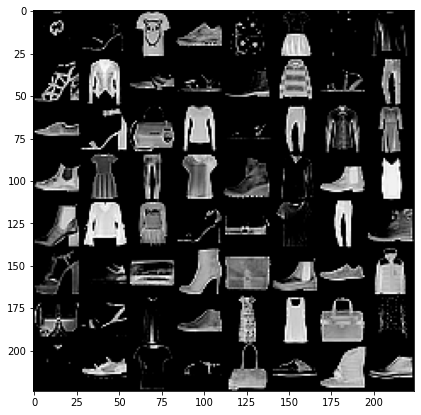

In [6]:
## 데이터셋 시각화하기
# 배치 1개의 image와 label 들을 확인해보기(64개 이미지 존재)
dataiter = iter(loader)
images, labels = next(dataiter)
# 시각화 하기
img = utils.make_grid(images, padding=0)
# 원래 이미지 -> 64개(1epoch, channel, height, width)
print(images.shape)
print(labels.shape)
print(labels)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [7]:
# 클래스 딕셔너리로 만들기
CLASSES = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}
# labels 는 0부터 9까지의 숫자로 이루어져 있다.
# 이를 CLASSES에 있는 index와 일치시킨다.
print(labels)
for label in labels :
    index = label.item()
    print(CLASSES[index])

tensor([2, 5, 0, 7, 8, 3, 2, 2, 5, 4, 7, 5, 9, 4, 5, 1, 7, 5, 8, 2, 5, 1, 6, 3,
        9, 3, 1, 0, 9, 6, 9, 3, 9, 6, 3, 5, 8, 0, 1, 9, 5, 7, 8, 9, 8, 9, 7, 4,
        8, 5, 0, 9, 3, 6, 8, 6, 6, 7, 0, 5, 8, 5, 9, 9])
Pullover
Sandal
T-shirt/top
Sneaker
Bag
Dress
Pullover
Pullover
Sandal
Coat
Sneaker
Sandal
Ankle boot
Coat
Sandal
Trouser
Sneaker
Sandal
Bag
Pullover
Sandal
Trouser
Shirt
Dress
Ankle boot
Dress
Trouser
T-shirt/top
Ankle boot
Shirt
Ankle boot
Dress
Ankle boot
Shirt
Dress
Sandal
Bag
T-shirt/top
Trouser
Ankle boot
Sandal
Sneaker
Bag
Ankle boot
Bag
Ankle boot
Sneaker
Coat
Bag
Sandal
T-shirt/top
Ankle boot
Dress
Shirt
Bag
Shirt
Shirt
Sneaker
T-shirt/top
Sandal
Bag
Sandal
Ankle boot
Ankle boot


In [8]:
## 네트워크 설정 및 필요한 손실함수 구현하기
net = Fashion_MNIST_NET().to(device)
params = net.parameters()

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(params, lr=lr)

writer = SummaryWriter(log_dir=log_dir)

In [9]:
## 모델 요약
print(summary(net, (1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
         AvgPool2d-9             [-1, 64, 6, 6]               0
           Linear-10                  [-1, 300]         691,500
        Dropout2d-11                  [-1, 300]               0
           Linear-12                  [-1, 120]          36,120
           Linear-13                   [-1, 10]           1,210
Total params: 747,838
Trainable params:

In [10]:
## 트레이닝 시작하기
st_epoch = 0
for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()

    loss_arr = []
    acc_arr = []

    for  batch, (input, label) in enumerate(loader, 1):
        
        input = input.to(device)
        # input shape = (batch, channel, height, width)
#         print(input.shape)
        
        label = label.to(device)
        # label shape = (batch)
#         print(label.shape)
        
        output = net(input)
        # output shape = (batch, 10)
#         print(output.shape)
        
        # pred shape = (batch, 10)
        pred = fn_pred(output)
#         print(pred.shape)
        
        # 모든 model parameter의 gradient를 0으로 설정한다.(epoch마다 새롭게, loss 증가 방지)
        optim.zero_grad()

        # loss와 acc를 계산
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)
    
        # loss와 chain rule를 통해 각 layer의 gradient를 계산한다.
        loss.backward()
        
        # parameter를 update한다.
        optim.step()

        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TRAIN: EPOCH %04d/%04d | BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (epoch, num_epoch, batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))
    
    writer.add_scalar('loss', np.mean(loss_arr), epoch)
    writer.add_scalar('acc', np.mean(acc_arr), epoch)

    save(ckpt_dir = ckpt_dir, net=net, optim=optim, epoch=epoch)

writer.close()

TRAIN: EPOCH 0001/0010 | BATCH 0001/0938 | LOSS: 2.2994 | ACC 0.1562
TRAIN: EPOCH 0001/0010 | BATCH 0002/0938 | LOSS: 2.6267 | ACC 0.1484
TRAIN: EPOCH 0001/0010 | BATCH 0003/0938 | LOSS: 2.3306 | ACC 0.2344
TRAIN: EPOCH 0001/0010 | BATCH 0004/0938 | LOSS: 2.1544 | ACC 0.2812
TRAIN: EPOCH 0001/0010 | BATCH 0005/0938 | LOSS: 2.0325 | ACC 0.3406
TRAIN: EPOCH 0001/0010 | BATCH 0006/0938 | LOSS: 1.9179 | ACC 0.3958
TRAIN: EPOCH 0001/0010 | BATCH 0007/0938 | LOSS: 1.8279 | ACC 0.4241
TRAIN: EPOCH 0001/0010 | BATCH 0008/0938 | LOSS: 1.7343 | ACC 0.4512
TRAIN: EPOCH 0001/0010 | BATCH 0009/0938 | LOSS: 1.6526 | ACC 0.4635
TRAIN: EPOCH 0001/0010 | BATCH 0010/0938 | LOSS: 1.5678 | ACC 0.4953
TRAIN: EPOCH 0001/0010 | BATCH 0011/0938 | LOSS: 1.5289 | ACC 0.5071
TRAIN: EPOCH 0001/0010 | BATCH 0012/0938 | LOSS: 1.4752 | ACC 0.5182
TRAIN: EPOCH 0001/0010 | BATCH 0013/0938 | LOSS: 1.4220 | ACC 0.5373
TRAIN: EPOCH 0001/0010 | BATCH 0014/0938 | LOSS: 1.3947 | ACC 0.5424
TRAIN: EPOCH 0001/0010 | BATCH 001

TRAIN: EPOCH 0001/0010 | BATCH 0120/0938 | LOSS: 0.7392 | ACC 0.7378
TRAIN: EPOCH 0001/0010 | BATCH 0121/0938 | LOSS: 0.7364 | ACC 0.7386
TRAIN: EPOCH 0001/0010 | BATCH 0122/0938 | LOSS: 0.7356 | ACC 0.7389
TRAIN: EPOCH 0001/0010 | BATCH 0123/0938 | LOSS: 0.7359 | ACC 0.7391
TRAIN: EPOCH 0001/0010 | BATCH 0124/0938 | LOSS: 0.7320 | ACC 0.7409
TRAIN: EPOCH 0001/0010 | BATCH 0125/0938 | LOSS: 0.7303 | ACC 0.7412
TRAIN: EPOCH 0001/0010 | BATCH 0126/0938 | LOSS: 0.7284 | ACC 0.7417
TRAIN: EPOCH 0001/0010 | BATCH 0127/0938 | LOSS: 0.7263 | ACC 0.7422
TRAIN: EPOCH 0001/0010 | BATCH 0128/0938 | LOSS: 0.7243 | ACC 0.7427
TRAIN: EPOCH 0001/0010 | BATCH 0129/0938 | LOSS: 0.7237 | ACC 0.7426
TRAIN: EPOCH 0001/0010 | BATCH 0130/0938 | LOSS: 0.7220 | ACC 0.7429
TRAIN: EPOCH 0001/0010 | BATCH 0131/0938 | LOSS: 0.7207 | ACC 0.7438
TRAIN: EPOCH 0001/0010 | BATCH 0132/0938 | LOSS: 0.7190 | ACC 0.7441
TRAIN: EPOCH 0001/0010 | BATCH 0133/0938 | LOSS: 0.7187 | ACC 0.7442
TRAIN: EPOCH 0001/0010 | BATCH 013

TRAIN: EPOCH 0001/0010 | BATCH 0240/0938 | LOSS: 0.6240 | ACC 0.7800
TRAIN: EPOCH 0001/0010 | BATCH 0241/0938 | LOSS: 0.6228 | ACC 0.7803
TRAIN: EPOCH 0001/0010 | BATCH 0242/0938 | LOSS: 0.6219 | ACC 0.7805
TRAIN: EPOCH 0001/0010 | BATCH 0243/0938 | LOSS: 0.6204 | ACC 0.7809
TRAIN: EPOCH 0001/0010 | BATCH 0244/0938 | LOSS: 0.6198 | ACC 0.7811
TRAIN: EPOCH 0001/0010 | BATCH 0245/0938 | LOSS: 0.6185 | ACC 0.7816
TRAIN: EPOCH 0001/0010 | BATCH 0246/0938 | LOSS: 0.6186 | ACC 0.7814
TRAIN: EPOCH 0001/0010 | BATCH 0247/0938 | LOSS: 0.6191 | ACC 0.7813
TRAIN: EPOCH 0001/0010 | BATCH 0248/0938 | LOSS: 0.6189 | ACC 0.7815
TRAIN: EPOCH 0001/0010 | BATCH 0249/0938 | LOSS: 0.6182 | ACC 0.7816
TRAIN: EPOCH 0001/0010 | BATCH 0250/0938 | LOSS: 0.6170 | ACC 0.7821
TRAIN: EPOCH 0001/0010 | BATCH 0251/0938 | LOSS: 0.6170 | ACC 0.7820
TRAIN: EPOCH 0001/0010 | BATCH 0252/0938 | LOSS: 0.6167 | ACC 0.7821
TRAIN: EPOCH 0001/0010 | BATCH 0253/0938 | LOSS: 0.6161 | ACC 0.7822
TRAIN: EPOCH 0001/0010 | BATCH 025

TRAIN: EPOCH 0001/0010 | BATCH 0360/0938 | LOSS: 0.5691 | ACC 0.7989
TRAIN: EPOCH 0001/0010 | BATCH 0361/0938 | LOSS: 0.5686 | ACC 0.7990
TRAIN: EPOCH 0001/0010 | BATCH 0362/0938 | LOSS: 0.5690 | ACC 0.7988
TRAIN: EPOCH 0001/0010 | BATCH 0363/0938 | LOSS: 0.5683 | ACC 0.7991
TRAIN: EPOCH 0001/0010 | BATCH 0364/0938 | LOSS: 0.5672 | ACC 0.7996
TRAIN: EPOCH 0001/0010 | BATCH 0365/0938 | LOSS: 0.5668 | ACC 0.7996
TRAIN: EPOCH 0001/0010 | BATCH 0366/0938 | LOSS: 0.5664 | ACC 0.7999
TRAIN: EPOCH 0001/0010 | BATCH 0367/0938 | LOSS: 0.5661 | ACC 0.7999
TRAIN: EPOCH 0001/0010 | BATCH 0368/0938 | LOSS: 0.5656 | ACC 0.8001
TRAIN: EPOCH 0001/0010 | BATCH 0369/0938 | LOSS: 0.5650 | ACC 0.8003
TRAIN: EPOCH 0001/0010 | BATCH 0370/0938 | LOSS: 0.5646 | ACC 0.8004
TRAIN: EPOCH 0001/0010 | BATCH 0371/0938 | LOSS: 0.5641 | ACC 0.8005
TRAIN: EPOCH 0001/0010 | BATCH 0372/0938 | LOSS: 0.5636 | ACC 0.8007
TRAIN: EPOCH 0001/0010 | BATCH 0373/0938 | LOSS: 0.5633 | ACC 0.8009
TRAIN: EPOCH 0001/0010 | BATCH 037

TRAIN: EPOCH 0001/0010 | BATCH 0480/0938 | LOSS: 0.5303 | ACC 0.8123
TRAIN: EPOCH 0001/0010 | BATCH 0481/0938 | LOSS: 0.5300 | ACC 0.8124
TRAIN: EPOCH 0001/0010 | BATCH 0482/0938 | LOSS: 0.5295 | ACC 0.8125
TRAIN: EPOCH 0001/0010 | BATCH 0483/0938 | LOSS: 0.5291 | ACC 0.8128
TRAIN: EPOCH 0001/0010 | BATCH 0484/0938 | LOSS: 0.5289 | ACC 0.8129
TRAIN: EPOCH 0001/0010 | BATCH 0485/0938 | LOSS: 0.5288 | ACC 0.8130
TRAIN: EPOCH 0001/0010 | BATCH 0486/0938 | LOSS: 0.5286 | ACC 0.8131
TRAIN: EPOCH 0001/0010 | BATCH 0487/0938 | LOSS: 0.5285 | ACC 0.8132
TRAIN: EPOCH 0001/0010 | BATCH 0488/0938 | LOSS: 0.5280 | ACC 0.8134
TRAIN: EPOCH 0001/0010 | BATCH 0489/0938 | LOSS: 0.5278 | ACC 0.8134
TRAIN: EPOCH 0001/0010 | BATCH 0490/0938 | LOSS: 0.5278 | ACC 0.8134
TRAIN: EPOCH 0001/0010 | BATCH 0491/0938 | LOSS: 0.5277 | ACC 0.8135
TRAIN: EPOCH 0001/0010 | BATCH 0492/0938 | LOSS: 0.5277 | ACC 0.8135
TRAIN: EPOCH 0001/0010 | BATCH 0493/0938 | LOSS: 0.5272 | ACC 0.8137
TRAIN: EPOCH 0001/0010 | BATCH 049

TRAIN: EPOCH 0001/0010 | BATCH 0605/0938 | LOSS: 0.5024 | ACC 0.8219
TRAIN: EPOCH 0001/0010 | BATCH 0606/0938 | LOSS: 0.5025 | ACC 0.8219
TRAIN: EPOCH 0001/0010 | BATCH 0607/0938 | LOSS: 0.5023 | ACC 0.8219
TRAIN: EPOCH 0001/0010 | BATCH 0608/0938 | LOSS: 0.5023 | ACC 0.8218
TRAIN: EPOCH 0001/0010 | BATCH 0609/0938 | LOSS: 0.5019 | ACC 0.8219
TRAIN: EPOCH 0001/0010 | BATCH 0610/0938 | LOSS: 0.5017 | ACC 0.8220
TRAIN: EPOCH 0001/0010 | BATCH 0611/0938 | LOSS: 0.5014 | ACC 0.8221
TRAIN: EPOCH 0001/0010 | BATCH 0612/0938 | LOSS: 0.5011 | ACC 0.8222
TRAIN: EPOCH 0001/0010 | BATCH 0613/0938 | LOSS: 0.5009 | ACC 0.8223
TRAIN: EPOCH 0001/0010 | BATCH 0614/0938 | LOSS: 0.5004 | ACC 0.8225
TRAIN: EPOCH 0001/0010 | BATCH 0615/0938 | LOSS: 0.5003 | ACC 0.8225
TRAIN: EPOCH 0001/0010 | BATCH 0616/0938 | LOSS: 0.5000 | ACC 0.8226
TRAIN: EPOCH 0001/0010 | BATCH 0617/0938 | LOSS: 0.4997 | ACC 0.8228
TRAIN: EPOCH 0001/0010 | BATCH 0618/0938 | LOSS: 0.4993 | ACC 0.8229
TRAIN: EPOCH 0001/0010 | BATCH 061

TRAIN: EPOCH 0001/0010 | BATCH 0728/0938 | LOSS: 0.4814 | ACC 0.8295
TRAIN: EPOCH 0001/0010 | BATCH 0729/0938 | LOSS: 0.4810 | ACC 0.8296
TRAIN: EPOCH 0001/0010 | BATCH 0730/0938 | LOSS: 0.4807 | ACC 0.8298
TRAIN: EPOCH 0001/0010 | BATCH 0731/0938 | LOSS: 0.4804 | ACC 0.8299
TRAIN: EPOCH 0001/0010 | BATCH 0732/0938 | LOSS: 0.4802 | ACC 0.8299
TRAIN: EPOCH 0001/0010 | BATCH 0733/0938 | LOSS: 0.4799 | ACC 0.8300
TRAIN: EPOCH 0001/0010 | BATCH 0734/0938 | LOSS: 0.4797 | ACC 0.8300
TRAIN: EPOCH 0001/0010 | BATCH 0735/0938 | LOSS: 0.4797 | ACC 0.8300
TRAIN: EPOCH 0001/0010 | BATCH 0736/0938 | LOSS: 0.4795 | ACC 0.8301
TRAIN: EPOCH 0001/0010 | BATCH 0737/0938 | LOSS: 0.4792 | ACC 0.8302
TRAIN: EPOCH 0001/0010 | BATCH 0738/0938 | LOSS: 0.4790 | ACC 0.8302
TRAIN: EPOCH 0001/0010 | BATCH 0739/0938 | LOSS: 0.4788 | ACC 0.8304
TRAIN: EPOCH 0001/0010 | BATCH 0740/0938 | LOSS: 0.4786 | ACC 0.8305
TRAIN: EPOCH 0001/0010 | BATCH 0741/0938 | LOSS: 0.4784 | ACC 0.8305
TRAIN: EPOCH 0001/0010 | BATCH 074

TRAIN: EPOCH 0001/0010 | BATCH 0851/0938 | LOSS: 0.4588 | ACC 0.8375
TRAIN: EPOCH 0001/0010 | BATCH 0852/0938 | LOSS: 0.4585 | ACC 0.8376
TRAIN: EPOCH 0001/0010 | BATCH 0853/0938 | LOSS: 0.4582 | ACC 0.8377
TRAIN: EPOCH 0001/0010 | BATCH 0854/0938 | LOSS: 0.4583 | ACC 0.8377
TRAIN: EPOCH 0001/0010 | BATCH 0855/0938 | LOSS: 0.4583 | ACC 0.8377
TRAIN: EPOCH 0001/0010 | BATCH 0856/0938 | LOSS: 0.4582 | ACC 0.8378
TRAIN: EPOCH 0001/0010 | BATCH 0857/0938 | LOSS: 0.4580 | ACC 0.8379
TRAIN: EPOCH 0001/0010 | BATCH 0858/0938 | LOSS: 0.4580 | ACC 0.8379
TRAIN: EPOCH 0001/0010 | BATCH 0859/0938 | LOSS: 0.4578 | ACC 0.8379
TRAIN: EPOCH 0001/0010 | BATCH 0860/0938 | LOSS: 0.4576 | ACC 0.8380
TRAIN: EPOCH 0001/0010 | BATCH 0861/0938 | LOSS: 0.4573 | ACC 0.8382
TRAIN: EPOCH 0001/0010 | BATCH 0862/0938 | LOSS: 0.4571 | ACC 0.8382
TRAIN: EPOCH 0001/0010 | BATCH 0863/0938 | LOSS: 0.4570 | ACC 0.8383
TRAIN: EPOCH 0001/0010 | BATCH 0864/0938 | LOSS: 0.4570 | ACC 0.8382
TRAIN: EPOCH 0001/0010 | BATCH 086

TRAIN: EPOCH 0002/0010 | BATCH 0031/0938 | LOSS: 0.3043 | ACC 0.8962
TRAIN: EPOCH 0002/0010 | BATCH 0032/0938 | LOSS: 0.3099 | ACC 0.8945
TRAIN: EPOCH 0002/0010 | BATCH 0033/0938 | LOSS: 0.3127 | ACC 0.8944
TRAIN: EPOCH 0002/0010 | BATCH 0034/0938 | LOSS: 0.3164 | ACC 0.8929
TRAIN: EPOCH 0002/0010 | BATCH 0035/0938 | LOSS: 0.3174 | ACC 0.8920
TRAIN: EPOCH 0002/0010 | BATCH 0036/0938 | LOSS: 0.3160 | ACC 0.8928
TRAIN: EPOCH 0002/0010 | BATCH 0037/0938 | LOSS: 0.3158 | ACC 0.8927
TRAIN: EPOCH 0002/0010 | BATCH 0038/0938 | LOSS: 0.3203 | ACC 0.8906
TRAIN: EPOCH 0002/0010 | BATCH 0039/0938 | LOSS: 0.3241 | ACC 0.8898
TRAIN: EPOCH 0002/0010 | BATCH 0040/0938 | LOSS: 0.3289 | ACC 0.8879
TRAIN: EPOCH 0002/0010 | BATCH 0041/0938 | LOSS: 0.3323 | ACC 0.8864
TRAIN: EPOCH 0002/0010 | BATCH 0042/0938 | LOSS: 0.3299 | ACC 0.8873
TRAIN: EPOCH 0002/0010 | BATCH 0043/0938 | LOSS: 0.3290 | ACC 0.8870
TRAIN: EPOCH 0002/0010 | BATCH 0044/0938 | LOSS: 0.3283 | ACC 0.8871
TRAIN: EPOCH 0002/0010 | BATCH 004

TRAIN: EPOCH 0002/0010 | BATCH 0153/0938 | LOSS: 0.3239 | ACC 0.8846
TRAIN: EPOCH 0002/0010 | BATCH 0154/0938 | LOSS: 0.3251 | ACC 0.8842
TRAIN: EPOCH 0002/0010 | BATCH 0155/0938 | LOSS: 0.3256 | ACC 0.8838
TRAIN: EPOCH 0002/0010 | BATCH 0156/0938 | LOSS: 0.3256 | ACC 0.8838
TRAIN: EPOCH 0002/0010 | BATCH 0157/0938 | LOSS: 0.3250 | ACC 0.8842
TRAIN: EPOCH 0002/0010 | BATCH 0158/0938 | LOSS: 0.3261 | ACC 0.8840
TRAIN: EPOCH 0002/0010 | BATCH 0159/0938 | LOSS: 0.3251 | ACC 0.8844
TRAIN: EPOCH 0002/0010 | BATCH 0160/0938 | LOSS: 0.3249 | ACC 0.8845
TRAIN: EPOCH 0002/0010 | BATCH 0161/0938 | LOSS: 0.3256 | ACC 0.8841
TRAIN: EPOCH 0002/0010 | BATCH 0162/0938 | LOSS: 0.3262 | ACC 0.8839
TRAIN: EPOCH 0002/0010 | BATCH 0163/0938 | LOSS: 0.3261 | ACC 0.8841
TRAIN: EPOCH 0002/0010 | BATCH 0164/0938 | LOSS: 0.3259 | ACC 0.8841
TRAIN: EPOCH 0002/0010 | BATCH 0165/0938 | LOSS: 0.3265 | ACC 0.8841
TRAIN: EPOCH 0002/0010 | BATCH 0166/0938 | LOSS: 0.3272 | ACC 0.8837
TRAIN: EPOCH 0002/0010 | BATCH 016

TRAIN: EPOCH 0002/0010 | BATCH 0275/0938 | LOSS: 0.3133 | ACC 0.8882
TRAIN: EPOCH 0002/0010 | BATCH 0276/0938 | LOSS: 0.3131 | ACC 0.8882
TRAIN: EPOCH 0002/0010 | BATCH 0277/0938 | LOSS: 0.3129 | ACC 0.8883
TRAIN: EPOCH 0002/0010 | BATCH 0278/0938 | LOSS: 0.3128 | ACC 0.8883
TRAIN: EPOCH 0002/0010 | BATCH 0279/0938 | LOSS: 0.3125 | ACC 0.8884
TRAIN: EPOCH 0002/0010 | BATCH 0280/0938 | LOSS: 0.3121 | ACC 0.8886
TRAIN: EPOCH 0002/0010 | BATCH 0281/0938 | LOSS: 0.3125 | ACC 0.8885
TRAIN: EPOCH 0002/0010 | BATCH 0282/0938 | LOSS: 0.3128 | ACC 0.8885
TRAIN: EPOCH 0002/0010 | BATCH 0283/0938 | LOSS: 0.3130 | ACC 0.8882
TRAIN: EPOCH 0002/0010 | BATCH 0284/0938 | LOSS: 0.3133 | ACC 0.8881
TRAIN: EPOCH 0002/0010 | BATCH 0285/0938 | LOSS: 0.3135 | ACC 0.8880
TRAIN: EPOCH 0002/0010 | BATCH 0286/0938 | LOSS: 0.3138 | ACC 0.8878
TRAIN: EPOCH 0002/0010 | BATCH 0287/0938 | LOSS: 0.3140 | ACC 0.8876
TRAIN: EPOCH 0002/0010 | BATCH 0288/0938 | LOSS: 0.3138 | ACC 0.8878
TRAIN: EPOCH 0002/0010 | BATCH 028

TRAIN: EPOCH 0002/0010 | BATCH 0397/0938 | LOSS: 0.3105 | ACC 0.8885
TRAIN: EPOCH 0002/0010 | BATCH 0398/0938 | LOSS: 0.3101 | ACC 0.8887
TRAIN: EPOCH 0002/0010 | BATCH 0399/0938 | LOSS: 0.3103 | ACC 0.8886
TRAIN: EPOCH 0002/0010 | BATCH 0400/0938 | LOSS: 0.3104 | ACC 0.8887
TRAIN: EPOCH 0002/0010 | BATCH 0401/0938 | LOSS: 0.3107 | ACC 0.8885
TRAIN: EPOCH 0002/0010 | BATCH 0402/0938 | LOSS: 0.3111 | ACC 0.8884
TRAIN: EPOCH 0002/0010 | BATCH 0403/0938 | LOSS: 0.3114 | ACC 0.8883
TRAIN: EPOCH 0002/0010 | BATCH 0404/0938 | LOSS: 0.3114 | ACC 0.8882
TRAIN: EPOCH 0002/0010 | BATCH 0405/0938 | LOSS: 0.3115 | ACC 0.8882
TRAIN: EPOCH 0002/0010 | BATCH 0406/0938 | LOSS: 0.3110 | ACC 0.8883
TRAIN: EPOCH 0002/0010 | BATCH 0407/0938 | LOSS: 0.3106 | ACC 0.8884
TRAIN: EPOCH 0002/0010 | BATCH 0408/0938 | LOSS: 0.3105 | ACC 0.8884
TRAIN: EPOCH 0002/0010 | BATCH 0409/0938 | LOSS: 0.3104 | ACC 0.8884
TRAIN: EPOCH 0002/0010 | BATCH 0410/0938 | LOSS: 0.3106 | ACC 0.8884
TRAIN: EPOCH 0002/0010 | BATCH 041

TRAIN: EPOCH 0002/0010 | BATCH 0516/0938 | LOSS: 0.3116 | ACC 0.8891
TRAIN: EPOCH 0002/0010 | BATCH 0517/0938 | LOSS: 0.3113 | ACC 0.8892
TRAIN: EPOCH 0002/0010 | BATCH 0518/0938 | LOSS: 0.3114 | ACC 0.8891
TRAIN: EPOCH 0002/0010 | BATCH 0519/0938 | LOSS: 0.3110 | ACC 0.8893
TRAIN: EPOCH 0002/0010 | BATCH 0520/0938 | LOSS: 0.3110 | ACC 0.8894
TRAIN: EPOCH 0002/0010 | BATCH 0521/0938 | LOSS: 0.3112 | ACC 0.8893
TRAIN: EPOCH 0002/0010 | BATCH 0522/0938 | LOSS: 0.3112 | ACC 0.8894
TRAIN: EPOCH 0002/0010 | BATCH 0523/0938 | LOSS: 0.3111 | ACC 0.8894
TRAIN: EPOCH 0002/0010 | BATCH 0524/0938 | LOSS: 0.3112 | ACC 0.8893
TRAIN: EPOCH 0002/0010 | BATCH 0525/0938 | LOSS: 0.3114 | ACC 0.8891
TRAIN: EPOCH 0002/0010 | BATCH 0526/0938 | LOSS: 0.3111 | ACC 0.8892
TRAIN: EPOCH 0002/0010 | BATCH 0527/0938 | LOSS: 0.3113 | ACC 0.8891
TRAIN: EPOCH 0002/0010 | BATCH 0528/0938 | LOSS: 0.3111 | ACC 0.8891
TRAIN: EPOCH 0002/0010 | BATCH 0529/0938 | LOSS: 0.3113 | ACC 0.8891
TRAIN: EPOCH 0002/0010 | BATCH 053

TRAIN: EPOCH 0002/0010 | BATCH 0635/0938 | LOSS: 0.3093 | ACC 0.8899
TRAIN: EPOCH 0002/0010 | BATCH 0636/0938 | LOSS: 0.3093 | ACC 0.8899
TRAIN: EPOCH 0002/0010 | BATCH 0637/0938 | LOSS: 0.3091 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0638/0938 | LOSS: 0.3090 | ACC 0.8899
TRAIN: EPOCH 0002/0010 | BATCH 0639/0938 | LOSS: 0.3090 | ACC 0.8899
TRAIN: EPOCH 0002/0010 | BATCH 0640/0938 | LOSS: 0.3090 | ACC 0.8898
TRAIN: EPOCH 0002/0010 | BATCH 0641/0938 | LOSS: 0.3090 | ACC 0.8898
TRAIN: EPOCH 0002/0010 | BATCH 0642/0938 | LOSS: 0.3089 | ACC 0.8898
TRAIN: EPOCH 0002/0010 | BATCH 0643/0938 | LOSS: 0.3087 | ACC 0.8898
TRAIN: EPOCH 0002/0010 | BATCH 0644/0938 | LOSS: 0.3086 | ACC 0.8899
TRAIN: EPOCH 0002/0010 | BATCH 0645/0938 | LOSS: 0.3086 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0646/0938 | LOSS: 0.3085 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0647/0938 | LOSS: 0.3087 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0648/0938 | LOSS: 0.3087 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 064

TRAIN: EPOCH 0002/0010 | BATCH 0756/0938 | LOSS: 0.3071 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0757/0938 | LOSS: 0.3072 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0758/0938 | LOSS: 0.3072 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0759/0938 | LOSS: 0.3071 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0760/0938 | LOSS: 0.3071 | ACC 0.8901
TRAIN: EPOCH 0002/0010 | BATCH 0761/0938 | LOSS: 0.3069 | ACC 0.8902
TRAIN: EPOCH 0002/0010 | BATCH 0762/0938 | LOSS: 0.3069 | ACC 0.8901
TRAIN: EPOCH 0002/0010 | BATCH 0763/0938 | LOSS: 0.3069 | ACC 0.8901
TRAIN: EPOCH 0002/0010 | BATCH 0764/0938 | LOSS: 0.3071 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0765/0938 | LOSS: 0.3073 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0766/0938 | LOSS: 0.3075 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0767/0938 | LOSS: 0.3076 | ACC 0.8900
TRAIN: EPOCH 0002/0010 | BATCH 0768/0938 | LOSS: 0.3074 | ACC 0.8901
TRAIN: EPOCH 0002/0010 | BATCH 0769/0938 | LOSS: 0.3073 | ACC 0.8901
TRAIN: EPOCH 0002/0010 | BATCH 077

TRAIN: EPOCH 0002/0010 | BATCH 0876/0938 | LOSS: 0.3049 | ACC 0.8916
TRAIN: EPOCH 0002/0010 | BATCH 0877/0938 | LOSS: 0.3049 | ACC 0.8916
TRAIN: EPOCH 0002/0010 | BATCH 0878/0938 | LOSS: 0.3049 | ACC 0.8916
TRAIN: EPOCH 0002/0010 | BATCH 0879/0938 | LOSS: 0.3051 | ACC 0.8916
TRAIN: EPOCH 0002/0010 | BATCH 0880/0938 | LOSS: 0.3052 | ACC 0.8917
TRAIN: EPOCH 0002/0010 | BATCH 0881/0938 | LOSS: 0.3051 | ACC 0.8917
TRAIN: EPOCH 0002/0010 | BATCH 0882/0938 | LOSS: 0.3050 | ACC 0.8917
TRAIN: EPOCH 0002/0010 | BATCH 0883/0938 | LOSS: 0.3050 | ACC 0.8917
TRAIN: EPOCH 0002/0010 | BATCH 0884/0938 | LOSS: 0.3048 | ACC 0.8918
TRAIN: EPOCH 0002/0010 | BATCH 0885/0938 | LOSS: 0.3047 | ACC 0.8919
TRAIN: EPOCH 0002/0010 | BATCH 0886/0938 | LOSS: 0.3048 | ACC 0.8918
TRAIN: EPOCH 0002/0010 | BATCH 0887/0938 | LOSS: 0.3048 | ACC 0.8918
TRAIN: EPOCH 0002/0010 | BATCH 0888/0938 | LOSS: 0.3048 | ACC 0.8917
TRAIN: EPOCH 0002/0010 | BATCH 0889/0938 | LOSS: 0.3048 | ACC 0.8917
TRAIN: EPOCH 0002/0010 | BATCH 089

TRAIN: EPOCH 0003/0010 | BATCH 0060/0938 | LOSS: 0.2715 | ACC 0.9023
TRAIN: EPOCH 0003/0010 | BATCH 0061/0938 | LOSS: 0.2701 | ACC 0.9027
TRAIN: EPOCH 0003/0010 | BATCH 0062/0938 | LOSS: 0.2713 | ACC 0.9020
TRAIN: EPOCH 0003/0010 | BATCH 0063/0938 | LOSS: 0.2707 | ACC 0.9023
TRAIN: EPOCH 0003/0010 | BATCH 0064/0938 | LOSS: 0.2695 | ACC 0.9031
TRAIN: EPOCH 0003/0010 | BATCH 0065/0938 | LOSS: 0.2699 | ACC 0.9029
TRAIN: EPOCH 0003/0010 | BATCH 0066/0938 | LOSS: 0.2678 | ACC 0.9036
TRAIN: EPOCH 0003/0010 | BATCH 0067/0938 | LOSS: 0.2668 | ACC 0.9037
TRAIN: EPOCH 0003/0010 | BATCH 0068/0938 | LOSS: 0.2671 | ACC 0.9037
TRAIN: EPOCH 0003/0010 | BATCH 0069/0938 | LOSS: 0.2675 | ACC 0.9040
TRAIN: EPOCH 0003/0010 | BATCH 0070/0938 | LOSS: 0.2667 | ACC 0.9045
TRAIN: EPOCH 0003/0010 | BATCH 0071/0938 | LOSS: 0.2648 | ACC 0.9054
TRAIN: EPOCH 0003/0010 | BATCH 0072/0938 | LOSS: 0.2657 | ACC 0.9045
TRAIN: EPOCH 0003/0010 | BATCH 0073/0938 | LOSS: 0.2638 | ACC 0.9054
TRAIN: EPOCH 0003/0010 | BATCH 007

TRAIN: EPOCH 0003/0010 | BATCH 0180/0938 | LOSS: 0.2596 | ACC 0.9075
TRAIN: EPOCH 0003/0010 | BATCH 0181/0938 | LOSS: 0.2588 | ACC 0.9078
TRAIN: EPOCH 0003/0010 | BATCH 0182/0938 | LOSS: 0.2586 | ACC 0.9077
TRAIN: EPOCH 0003/0010 | BATCH 0183/0938 | LOSS: 0.2580 | ACC 0.9080
TRAIN: EPOCH 0003/0010 | BATCH 0184/0938 | LOSS: 0.2585 | ACC 0.9077
TRAIN: EPOCH 0003/0010 | BATCH 0185/0938 | LOSS: 0.2585 | ACC 0.9078
TRAIN: EPOCH 0003/0010 | BATCH 0186/0938 | LOSS: 0.2580 | ACC 0.9080
TRAIN: EPOCH 0003/0010 | BATCH 0187/0938 | LOSS: 0.2578 | ACC 0.9079
TRAIN: EPOCH 0003/0010 | BATCH 0188/0938 | LOSS: 0.2579 | ACC 0.9077
TRAIN: EPOCH 0003/0010 | BATCH 0189/0938 | LOSS: 0.2587 | ACC 0.9077
TRAIN: EPOCH 0003/0010 | BATCH 0190/0938 | LOSS: 0.2583 | ACC 0.9078
TRAIN: EPOCH 0003/0010 | BATCH 0191/0938 | LOSS: 0.2574 | ACC 0.9082
TRAIN: EPOCH 0003/0010 | BATCH 0192/0938 | LOSS: 0.2578 | ACC 0.9080
TRAIN: EPOCH 0003/0010 | BATCH 0193/0938 | LOSS: 0.2582 | ACC 0.9080
TRAIN: EPOCH 0003/0010 | BATCH 019

TRAIN: EPOCH 0003/0010 | BATCH 0299/0938 | LOSS: 0.2634 | ACC 0.9058
TRAIN: EPOCH 0003/0010 | BATCH 0300/0938 | LOSS: 0.2635 | ACC 0.9056
TRAIN: EPOCH 0003/0010 | BATCH 0301/0938 | LOSS: 0.2638 | ACC 0.9055
TRAIN: EPOCH 0003/0010 | BATCH 0302/0938 | LOSS: 0.2637 | ACC 0.9055
TRAIN: EPOCH 0003/0010 | BATCH 0303/0938 | LOSS: 0.2636 | ACC 0.9055
TRAIN: EPOCH 0003/0010 | BATCH 0304/0938 | LOSS: 0.2636 | ACC 0.9055
TRAIN: EPOCH 0003/0010 | BATCH 0305/0938 | LOSS: 0.2631 | ACC 0.9057
TRAIN: EPOCH 0003/0010 | BATCH 0306/0938 | LOSS: 0.2632 | ACC 0.9057
TRAIN: EPOCH 0003/0010 | BATCH 0307/0938 | LOSS: 0.2632 | ACC 0.9057
TRAIN: EPOCH 0003/0010 | BATCH 0308/0938 | LOSS: 0.2630 | ACC 0.9058
TRAIN: EPOCH 0003/0010 | BATCH 0309/0938 | LOSS: 0.2633 | ACC 0.9057
TRAIN: EPOCH 0003/0010 | BATCH 0310/0938 | LOSS: 0.2632 | ACC 0.9058
TRAIN: EPOCH 0003/0010 | BATCH 0311/0938 | LOSS: 0.2637 | ACC 0.9057
TRAIN: EPOCH 0003/0010 | BATCH 0312/0938 | LOSS: 0.2633 | ACC 0.9058
TRAIN: EPOCH 0003/0010 | BATCH 031

TRAIN: EPOCH 0003/0010 | BATCH 0418/0938 | LOSS: 0.2616 | ACC 0.9067
TRAIN: EPOCH 0003/0010 | BATCH 0419/0938 | LOSS: 0.2619 | ACC 0.9066
TRAIN: EPOCH 0003/0010 | BATCH 0420/0938 | LOSS: 0.2618 | ACC 0.9067
TRAIN: EPOCH 0003/0010 | BATCH 0421/0938 | LOSS: 0.2615 | ACC 0.9068
TRAIN: EPOCH 0003/0010 | BATCH 0422/0938 | LOSS: 0.2615 | ACC 0.9068
TRAIN: EPOCH 0003/0010 | BATCH 0423/0938 | LOSS: 0.2615 | ACC 0.9067
TRAIN: EPOCH 0003/0010 | BATCH 0424/0938 | LOSS: 0.2618 | ACC 0.9065
TRAIN: EPOCH 0003/0010 | BATCH 0425/0938 | LOSS: 0.2618 | ACC 0.9065
TRAIN: EPOCH 0003/0010 | BATCH 0426/0938 | LOSS: 0.2617 | ACC 0.9066
TRAIN: EPOCH 0003/0010 | BATCH 0427/0938 | LOSS: 0.2623 | ACC 0.9064
TRAIN: EPOCH 0003/0010 | BATCH 0428/0938 | LOSS: 0.2620 | ACC 0.9065
TRAIN: EPOCH 0003/0010 | BATCH 0429/0938 | LOSS: 0.2618 | ACC 0.9065
TRAIN: EPOCH 0003/0010 | BATCH 0430/0938 | LOSS: 0.2619 | ACC 0.9064
TRAIN: EPOCH 0003/0010 | BATCH 0431/0938 | LOSS: 0.2617 | ACC 0.9065
TRAIN: EPOCH 0003/0010 | BATCH 043

TRAIN: EPOCH 0003/0010 | BATCH 0542/0938 | LOSS: 0.2637 | ACC 0.9052
TRAIN: EPOCH 0003/0010 | BATCH 0543/0938 | LOSS: 0.2641 | ACC 0.9050
TRAIN: EPOCH 0003/0010 | BATCH 0544/0938 | LOSS: 0.2642 | ACC 0.9050
TRAIN: EPOCH 0003/0010 | BATCH 0545/0938 | LOSS: 0.2646 | ACC 0.9049
TRAIN: EPOCH 0003/0010 | BATCH 0546/0938 | LOSS: 0.2649 | ACC 0.9048
TRAIN: EPOCH 0003/0010 | BATCH 0547/0938 | LOSS: 0.2646 | ACC 0.9049
TRAIN: EPOCH 0003/0010 | BATCH 0548/0938 | LOSS: 0.2645 | ACC 0.9049
TRAIN: EPOCH 0003/0010 | BATCH 0549/0938 | LOSS: 0.2645 | ACC 0.9049
TRAIN: EPOCH 0003/0010 | BATCH 0550/0938 | LOSS: 0.2644 | ACC 0.9049
TRAIN: EPOCH 0003/0010 | BATCH 0551/0938 | LOSS: 0.2647 | ACC 0.9048
TRAIN: EPOCH 0003/0010 | BATCH 0552/0938 | LOSS: 0.2646 | ACC 0.9048
TRAIN: EPOCH 0003/0010 | BATCH 0553/0938 | LOSS: 0.2645 | ACC 0.9048
TRAIN: EPOCH 0003/0010 | BATCH 0554/0938 | LOSS: 0.2647 | ACC 0.9048
TRAIN: EPOCH 0003/0010 | BATCH 0555/0938 | LOSS: 0.2647 | ACC 0.9048
TRAIN: EPOCH 0003/0010 | BATCH 055

TRAIN: EPOCH 0003/0010 | BATCH 0666/0938 | LOSS: 0.2669 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0667/0938 | LOSS: 0.2668 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0668/0938 | LOSS: 0.2670 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0669/0938 | LOSS: 0.2669 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0670/0938 | LOSS: 0.2670 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0671/0938 | LOSS: 0.2670 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0672/0938 | LOSS: 0.2669 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0673/0938 | LOSS: 0.2668 | ACC 0.9045
TRAIN: EPOCH 0003/0010 | BATCH 0674/0938 | LOSS: 0.2669 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0675/0938 | LOSS: 0.2669 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0676/0938 | LOSS: 0.2668 | ACC 0.9045
TRAIN: EPOCH 0003/0010 | BATCH 0677/0938 | LOSS: 0.2667 | ACC 0.9046
TRAIN: EPOCH 0003/0010 | BATCH 0678/0938 | LOSS: 0.2666 | ACC 0.9045
TRAIN: EPOCH 0003/0010 | BATCH 0679/0938 | LOSS: 0.2665 | ACC 0.9046
TRAIN: EPOCH 0003/0010 | BATCH 068

TRAIN: EPOCH 0003/0010 | BATCH 0789/0938 | LOSS: 0.2659 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0790/0938 | LOSS: 0.2660 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0791/0938 | LOSS: 0.2661 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0792/0938 | LOSS: 0.2663 | ACC 0.9042
TRAIN: EPOCH 0003/0010 | BATCH 0793/0938 | LOSS: 0.2661 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0794/0938 | LOSS: 0.2660 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0795/0938 | LOSS: 0.2661 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0796/0938 | LOSS: 0.2660 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0797/0938 | LOSS: 0.2659 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0798/0938 | LOSS: 0.2658 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0799/0938 | LOSS: 0.2660 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0800/0938 | LOSS: 0.2662 | ACC 0.9044
TRAIN: EPOCH 0003/0010 | BATCH 0801/0938 | LOSS: 0.2662 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 0802/0938 | LOSS: 0.2662 | ACC 0.9043
TRAIN: EPOCH 0003/0010 | BATCH 080

TRAIN: EPOCH 0003/0010 | BATCH 0909/0938 | LOSS: 0.2628 | ACC 0.9058
TRAIN: EPOCH 0003/0010 | BATCH 0910/0938 | LOSS: 0.2626 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0911/0938 | LOSS: 0.2627 | ACC 0.9058
TRAIN: EPOCH 0003/0010 | BATCH 0912/0938 | LOSS: 0.2626 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0913/0938 | LOSS: 0.2625 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0914/0938 | LOSS: 0.2626 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0915/0938 | LOSS: 0.2628 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0916/0938 | LOSS: 0.2627 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0917/0938 | LOSS: 0.2626 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0918/0938 | LOSS: 0.2626 | ACC 0.9059
TRAIN: EPOCH 0003/0010 | BATCH 0919/0938 | LOSS: 0.2624 | ACC 0.9060
TRAIN: EPOCH 0003/0010 | BATCH 0920/0938 | LOSS: 0.2623 | ACC 0.9061
TRAIN: EPOCH 0003/0010 | BATCH 0921/0938 | LOSS: 0.2624 | ACC 0.9061
TRAIN: EPOCH 0003/0010 | BATCH 0922/0938 | LOSS: 0.2624 | ACC 0.9061
TRAIN: EPOCH 0003/0010 | BATCH 092

TRAIN: EPOCH 0004/0010 | BATCH 0093/0938 | LOSS: 0.2341 | ACC 0.9143
TRAIN: EPOCH 0004/0010 | BATCH 0094/0938 | LOSS: 0.2345 | ACC 0.9137
TRAIN: EPOCH 0004/0010 | BATCH 0095/0938 | LOSS: 0.2343 | ACC 0.9133
TRAIN: EPOCH 0004/0010 | BATCH 0096/0938 | LOSS: 0.2340 | ACC 0.9137
TRAIN: EPOCH 0004/0010 | BATCH 0097/0938 | LOSS: 0.2351 | ACC 0.9138
TRAIN: EPOCH 0004/0010 | BATCH 0098/0938 | LOSS: 0.2343 | ACC 0.9139
TRAIN: EPOCH 0004/0010 | BATCH 0099/0938 | LOSS: 0.2344 | ACC 0.9134
TRAIN: EPOCH 0004/0010 | BATCH 0100/0938 | LOSS: 0.2338 | ACC 0.9134
TRAIN: EPOCH 0004/0010 | BATCH 0101/0938 | LOSS: 0.2341 | ACC 0.9137
TRAIN: EPOCH 0004/0010 | BATCH 0102/0938 | LOSS: 0.2334 | ACC 0.9139
TRAIN: EPOCH 0004/0010 | BATCH 0103/0938 | LOSS: 0.2330 | ACC 0.9141
TRAIN: EPOCH 0004/0010 | BATCH 0104/0938 | LOSS: 0.2313 | ACC 0.9150
TRAIN: EPOCH 0004/0010 | BATCH 0105/0938 | LOSS: 0.2323 | ACC 0.9146
TRAIN: EPOCH 0004/0010 | BATCH 0106/0938 | LOSS: 0.2334 | ACC 0.9141
TRAIN: EPOCH 0004/0010 | BATCH 010

TRAIN: EPOCH 0004/0010 | BATCH 0212/0938 | LOSS: 0.2440 | ACC 0.9125
TRAIN: EPOCH 0004/0010 | BATCH 0213/0938 | LOSS: 0.2438 | ACC 0.9125
TRAIN: EPOCH 0004/0010 | BATCH 0214/0938 | LOSS: 0.2435 | ACC 0.9126
TRAIN: EPOCH 0004/0010 | BATCH 0215/0938 | LOSS: 0.2432 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0216/0938 | LOSS: 0.2429 | ACC 0.9128
TRAIN: EPOCH 0004/0010 | BATCH 0217/0938 | LOSS: 0.2428 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0218/0938 | LOSS: 0.2424 | ACC 0.9128
TRAIN: EPOCH 0004/0010 | BATCH 0219/0938 | LOSS: 0.2428 | ACC 0.9128
TRAIN: EPOCH 0004/0010 | BATCH 0220/0938 | LOSS: 0.2425 | ACC 0.9130
TRAIN: EPOCH 0004/0010 | BATCH 0221/0938 | LOSS: 0.2423 | ACC 0.9130
TRAIN: EPOCH 0004/0010 | BATCH 0222/0938 | LOSS: 0.2428 | ACC 0.9130
TRAIN: EPOCH 0004/0010 | BATCH 0223/0938 | LOSS: 0.2425 | ACC 0.9131
TRAIN: EPOCH 0004/0010 | BATCH 0224/0938 | LOSS: 0.2426 | ACC 0.9129
TRAIN: EPOCH 0004/0010 | BATCH 0225/0938 | LOSS: 0.2431 | ACC 0.9128
TRAIN: EPOCH 0004/0010 | BATCH 022

TRAIN: EPOCH 0004/0010 | BATCH 0333/0938 | LOSS: 0.2411 | ACC 0.9126
TRAIN: EPOCH 0004/0010 | BATCH 0334/0938 | LOSS: 0.2414 | ACC 0.9126
TRAIN: EPOCH 0004/0010 | BATCH 0335/0938 | LOSS: 0.2410 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0336/0938 | LOSS: 0.2408 | ACC 0.9128
TRAIN: EPOCH 0004/0010 | BATCH 0337/0938 | LOSS: 0.2406 | ACC 0.9129
TRAIN: EPOCH 0004/0010 | BATCH 0338/0938 | LOSS: 0.2408 | ACC 0.9126
TRAIN: EPOCH 0004/0010 | BATCH 0339/0938 | LOSS: 0.2409 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0340/0938 | LOSS: 0.2410 | ACC 0.9126
TRAIN: EPOCH 0004/0010 | BATCH 0341/0938 | LOSS: 0.2406 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0342/0938 | LOSS: 0.2404 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0343/0938 | LOSS: 0.2406 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0344/0938 | LOSS: 0.2407 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0345/0938 | LOSS: 0.2408 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 0346/0938 | LOSS: 0.2410 | ACC 0.9127
TRAIN: EPOCH 0004/0010 | BATCH 034

TRAIN: EPOCH 0004/0010 | BATCH 0452/0938 | LOSS: 0.2407 | ACC 0.9131
TRAIN: EPOCH 0004/0010 | BATCH 0453/0938 | LOSS: 0.2406 | ACC 0.9133
TRAIN: EPOCH 0004/0010 | BATCH 0454/0938 | LOSS: 0.2408 | ACC 0.9132
TRAIN: EPOCH 0004/0010 | BATCH 0455/0938 | LOSS: 0.2415 | ACC 0.9131
TRAIN: EPOCH 0004/0010 | BATCH 0456/0938 | LOSS: 0.2415 | ACC 0.9130
TRAIN: EPOCH 0004/0010 | BATCH 0457/0938 | LOSS: 0.2415 | ACC 0.9130
TRAIN: EPOCH 0004/0010 | BATCH 0458/0938 | LOSS: 0.2415 | ACC 0.9131
TRAIN: EPOCH 0004/0010 | BATCH 0459/0938 | LOSS: 0.2414 | ACC 0.9131
TRAIN: EPOCH 0004/0010 | BATCH 0460/0938 | LOSS: 0.2411 | ACC 0.9132
TRAIN: EPOCH 0004/0010 | BATCH 0461/0938 | LOSS: 0.2409 | ACC 0.9133
TRAIN: EPOCH 0004/0010 | BATCH 0462/0938 | LOSS: 0.2405 | ACC 0.9135
TRAIN: EPOCH 0004/0010 | BATCH 0463/0938 | LOSS: 0.2405 | ACC 0.9136
TRAIN: EPOCH 0004/0010 | BATCH 0464/0938 | LOSS: 0.2405 | ACC 0.9136
TRAIN: EPOCH 0004/0010 | BATCH 0465/0938 | LOSS: 0.2404 | ACC 0.9135
TRAIN: EPOCH 0004/0010 | BATCH 046

TRAIN: EPOCH 0004/0010 | BATCH 0575/0938 | LOSS: 0.2392 | ACC 0.9141
TRAIN: EPOCH 0004/0010 | BATCH 0576/0938 | LOSS: 0.2394 | ACC 0.9141
TRAIN: EPOCH 0004/0010 | BATCH 0577/0938 | LOSS: 0.2392 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0578/0938 | LOSS: 0.2391 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0579/0938 | LOSS: 0.2391 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0580/0938 | LOSS: 0.2393 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0581/0938 | LOSS: 0.2396 | ACC 0.9140
TRAIN: EPOCH 0004/0010 | BATCH 0582/0938 | LOSS: 0.2396 | ACC 0.9141
TRAIN: EPOCH 0004/0010 | BATCH 0583/0938 | LOSS: 0.2396 | ACC 0.9141
TRAIN: EPOCH 0004/0010 | BATCH 0584/0938 | LOSS: 0.2395 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0585/0938 | LOSS: 0.2394 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0586/0938 | LOSS: 0.2394 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0587/0938 | LOSS: 0.2393 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 0588/0938 | LOSS: 0.2393 | ACC 0.9142
TRAIN: EPOCH 0004/0010 | BATCH 058

TRAIN: EPOCH 0004/0010 | BATCH 0695/0938 | LOSS: 0.2387 | ACC 0.9143
TRAIN: EPOCH 0004/0010 | BATCH 0696/0938 | LOSS: 0.2387 | ACC 0.9143
TRAIN: EPOCH 0004/0010 | BATCH 0697/0938 | LOSS: 0.2386 | ACC 0.9143
TRAIN: EPOCH 0004/0010 | BATCH 0698/0938 | LOSS: 0.2387 | ACC 0.9144
TRAIN: EPOCH 0004/0010 | BATCH 0699/0938 | LOSS: 0.2388 | ACC 0.9144
TRAIN: EPOCH 0004/0010 | BATCH 0700/0938 | LOSS: 0.2388 | ACC 0.9144
TRAIN: EPOCH 0004/0010 | BATCH 0701/0938 | LOSS: 0.2386 | ACC 0.9145
TRAIN: EPOCH 0004/0010 | BATCH 0702/0938 | LOSS: 0.2388 | ACC 0.9144
TRAIN: EPOCH 0004/0010 | BATCH 0703/0938 | LOSS: 0.2386 | ACC 0.9145
TRAIN: EPOCH 0004/0010 | BATCH 0704/0938 | LOSS: 0.2387 | ACC 0.9144
TRAIN: EPOCH 0004/0010 | BATCH 0705/0938 | LOSS: 0.2385 | ACC 0.9145
TRAIN: EPOCH 0004/0010 | BATCH 0706/0938 | LOSS: 0.2386 | ACC 0.9144
TRAIN: EPOCH 0004/0010 | BATCH 0707/0938 | LOSS: 0.2384 | ACC 0.9145
TRAIN: EPOCH 0004/0010 | BATCH 0708/0938 | LOSS: 0.2383 | ACC 0.9145
TRAIN: EPOCH 0004/0010 | BATCH 070

TRAIN: EPOCH 0004/0010 | BATCH 0817/0938 | LOSS: 0.2385 | ACC 0.9148
TRAIN: EPOCH 0004/0010 | BATCH 0818/0938 | LOSS: 0.2386 | ACC 0.9148
TRAIN: EPOCH 0004/0010 | BATCH 0819/0938 | LOSS: 0.2384 | ACC 0.9148
TRAIN: EPOCH 0004/0010 | BATCH 0820/0938 | LOSS: 0.2384 | ACC 0.9148
TRAIN: EPOCH 0004/0010 | BATCH 0821/0938 | LOSS: 0.2385 | ACC 0.9148
TRAIN: EPOCH 0004/0010 | BATCH 0822/0938 | LOSS: 0.2384 | ACC 0.9147
TRAIN: EPOCH 0004/0010 | BATCH 0823/0938 | LOSS: 0.2383 | ACC 0.9148
TRAIN: EPOCH 0004/0010 | BATCH 0824/0938 | LOSS: 0.2385 | ACC 0.9147
TRAIN: EPOCH 0004/0010 | BATCH 0825/0938 | LOSS: 0.2385 | ACC 0.9147
TRAIN: EPOCH 0004/0010 | BATCH 0826/0938 | LOSS: 0.2385 | ACC 0.9147
TRAIN: EPOCH 0004/0010 | BATCH 0827/0938 | LOSS: 0.2386 | ACC 0.9146
TRAIN: EPOCH 0004/0010 | BATCH 0828/0938 | LOSS: 0.2385 | ACC 0.9146
TRAIN: EPOCH 0004/0010 | BATCH 0829/0938 | LOSS: 0.2385 | ACC 0.9146
TRAIN: EPOCH 0004/0010 | BATCH 0830/0938 | LOSS: 0.2387 | ACC 0.9146
TRAIN: EPOCH 0004/0010 | BATCH 083

TRAIN: EPOCH 0004/0010 | BATCH 0936/0938 | LOSS: 0.2379 | ACC 0.9147
TRAIN: EPOCH 0004/0010 | BATCH 0937/0938 | LOSS: 0.2381 | ACC 0.9146
TRAIN: EPOCH 0004/0010 | BATCH 0938/0938 | LOSS: 0.2378 | ACC 0.9147
TRAIN: EPOCH 0005/0010 | BATCH 0001/0938 | LOSS: 0.0889 | ACC 0.9688
TRAIN: EPOCH 0005/0010 | BATCH 0002/0938 | LOSS: 0.1898 | ACC 0.9297
TRAIN: EPOCH 0005/0010 | BATCH 0003/0938 | LOSS: 0.2081 | ACC 0.9115
TRAIN: EPOCH 0005/0010 | BATCH 0004/0938 | LOSS: 0.1944 | ACC 0.9219
TRAIN: EPOCH 0005/0010 | BATCH 0005/0938 | LOSS: 0.1961 | ACC 0.9219
TRAIN: EPOCH 0005/0010 | BATCH 0006/0938 | LOSS: 0.1871 | ACC 0.9245
TRAIN: EPOCH 0005/0010 | BATCH 0007/0938 | LOSS: 0.1809 | ACC 0.9241
TRAIN: EPOCH 0005/0010 | BATCH 0008/0938 | LOSS: 0.1891 | ACC 0.9160
TRAIN: EPOCH 0005/0010 | BATCH 0009/0938 | LOSS: 0.1848 | ACC 0.9184
TRAIN: EPOCH 0005/0010 | BATCH 0010/0938 | LOSS: 0.1836 | ACC 0.9156
TRAIN: EPOCH 0005/0010 | BATCH 0011/0938 | LOSS: 0.1843 | ACC 0.9176
TRAIN: EPOCH 0005/0010 | BATCH 001

TRAIN: EPOCH 0005/0010 | BATCH 0116/0938 | LOSS: 0.2103 | ACC 0.9190
TRAIN: EPOCH 0005/0010 | BATCH 0117/0938 | LOSS: 0.2103 | ACC 0.9189
TRAIN: EPOCH 0005/0010 | BATCH 0118/0938 | LOSS: 0.2108 | ACC 0.9187
TRAIN: EPOCH 0005/0010 | BATCH 0119/0938 | LOSS: 0.2104 | ACC 0.9189
TRAIN: EPOCH 0005/0010 | BATCH 0120/0938 | LOSS: 0.2108 | ACC 0.9186
TRAIN: EPOCH 0005/0010 | BATCH 0121/0938 | LOSS: 0.2110 | ACC 0.9183
TRAIN: EPOCH 0005/0010 | BATCH 0122/0938 | LOSS: 0.2103 | ACC 0.9185
TRAIN: EPOCH 0005/0010 | BATCH 0123/0938 | LOSS: 0.2101 | ACC 0.9187
TRAIN: EPOCH 0005/0010 | BATCH 0124/0938 | LOSS: 0.2101 | ACC 0.9185
TRAIN: EPOCH 0005/0010 | BATCH 0125/0938 | LOSS: 0.2093 | ACC 0.9187
TRAIN: EPOCH 0005/0010 | BATCH 0126/0938 | LOSS: 0.2088 | ACC 0.9191
TRAIN: EPOCH 0005/0010 | BATCH 0127/0938 | LOSS: 0.2092 | ACC 0.9187
TRAIN: EPOCH 0005/0010 | BATCH 0128/0938 | LOSS: 0.2099 | ACC 0.9183
TRAIN: EPOCH 0005/0010 | BATCH 0129/0938 | LOSS: 0.2100 | ACC 0.9182
TRAIN: EPOCH 0005/0010 | BATCH 013

TRAIN: EPOCH 0005/0010 | BATCH 0235/0938 | LOSS: 0.2112 | ACC 0.9209
TRAIN: EPOCH 0005/0010 | BATCH 0236/0938 | LOSS: 0.2111 | ACC 0.9211
TRAIN: EPOCH 0005/0010 | BATCH 0237/0938 | LOSS: 0.2107 | ACC 0.9213
TRAIN: EPOCH 0005/0010 | BATCH 0238/0938 | LOSS: 0.2109 | ACC 0.9212
TRAIN: EPOCH 0005/0010 | BATCH 0239/0938 | LOSS: 0.2109 | ACC 0.9211
TRAIN: EPOCH 0005/0010 | BATCH 0240/0938 | LOSS: 0.2105 | ACC 0.9214
TRAIN: EPOCH 0005/0010 | BATCH 0241/0938 | LOSS: 0.2110 | ACC 0.9212
TRAIN: EPOCH 0005/0010 | BATCH 0242/0938 | LOSS: 0.2114 | ACC 0.9210
TRAIN: EPOCH 0005/0010 | BATCH 0243/0938 | LOSS: 0.2113 | ACC 0.9210
TRAIN: EPOCH 0005/0010 | BATCH 0244/0938 | LOSS: 0.2112 | ACC 0.9211
TRAIN: EPOCH 0005/0010 | BATCH 0245/0938 | LOSS: 0.2108 | ACC 0.9213
TRAIN: EPOCH 0005/0010 | BATCH 0246/0938 | LOSS: 0.2103 | ACC 0.9214
TRAIN: EPOCH 0005/0010 | BATCH 0247/0938 | LOSS: 0.2102 | ACC 0.9215
TRAIN: EPOCH 0005/0010 | BATCH 0248/0938 | LOSS: 0.2098 | ACC 0.9216
TRAIN: EPOCH 0005/0010 | BATCH 024

TRAIN: EPOCH 0005/0010 | BATCH 0354/0938 | LOSS: 0.2109 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0355/0938 | LOSS: 0.2106 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0356/0938 | LOSS: 0.2104 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0357/0938 | LOSS: 0.2103 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0358/0938 | LOSS: 0.2103 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0359/0938 | LOSS: 0.2101 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0360/0938 | LOSS: 0.2105 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0361/0938 | LOSS: 0.2106 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0362/0938 | LOSS: 0.2109 | ACC 0.9219
TRAIN: EPOCH 0005/0010 | BATCH 0363/0938 | LOSS: 0.2107 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0364/0938 | LOSS: 0.2108 | ACC 0.9219
TRAIN: EPOCH 0005/0010 | BATCH 0365/0938 | LOSS: 0.2111 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0366/0938 | LOSS: 0.2113 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0367/0938 | LOSS: 0.2113 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 036

TRAIN: EPOCH 0005/0010 | BATCH 0472/0938 | LOSS: 0.2122 | ACC 0.9216
TRAIN: EPOCH 0005/0010 | BATCH 0473/0938 | LOSS: 0.2120 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0474/0938 | LOSS: 0.2118 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0475/0938 | LOSS: 0.2119 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0476/0938 | LOSS: 0.2117 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0477/0938 | LOSS: 0.2119 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0478/0938 | LOSS: 0.2121 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0479/0938 | LOSS: 0.2123 | ACC 0.9216
TRAIN: EPOCH 0005/0010 | BATCH 0480/0938 | LOSS: 0.2124 | ACC 0.9216
TRAIN: EPOCH 0005/0010 | BATCH 0481/0938 | LOSS: 0.2124 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0482/0938 | LOSS: 0.2125 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0483/0938 | LOSS: 0.2128 | ACC 0.9216
TRAIN: EPOCH 0005/0010 | BATCH 0484/0938 | LOSS: 0.2128 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0485/0938 | LOSS: 0.2126 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 048

TRAIN: EPOCH 0005/0010 | BATCH 0591/0938 | LOSS: 0.2145 | ACC 0.9215
TRAIN: EPOCH 0005/0010 | BATCH 0592/0938 | LOSS: 0.2146 | ACC 0.9214
TRAIN: EPOCH 0005/0010 | BATCH 0593/0938 | LOSS: 0.2146 | ACC 0.9214
TRAIN: EPOCH 0005/0010 | BATCH 0594/0938 | LOSS: 0.2147 | ACC 0.9214
TRAIN: EPOCH 0005/0010 | BATCH 0595/0938 | LOSS: 0.2149 | ACC 0.9214
TRAIN: EPOCH 0005/0010 | BATCH 0596/0938 | LOSS: 0.2149 | ACC 0.9214
TRAIN: EPOCH 0005/0010 | BATCH 0597/0938 | LOSS: 0.2152 | ACC 0.9213
TRAIN: EPOCH 0005/0010 | BATCH 0598/0938 | LOSS: 0.2153 | ACC 0.9213
TRAIN: EPOCH 0005/0010 | BATCH 0599/0938 | LOSS: 0.2155 | ACC 0.9212
TRAIN: EPOCH 0005/0010 | BATCH 0600/0938 | LOSS: 0.2156 | ACC 0.9212
TRAIN: EPOCH 0005/0010 | BATCH 0601/0938 | LOSS: 0.2157 | ACC 0.9211
TRAIN: EPOCH 0005/0010 | BATCH 0602/0938 | LOSS: 0.2155 | ACC 0.9212
TRAIN: EPOCH 0005/0010 | BATCH 0603/0938 | LOSS: 0.2154 | ACC 0.9213
TRAIN: EPOCH 0005/0010 | BATCH 0604/0938 | LOSS: 0.2155 | ACC 0.9213
TRAIN: EPOCH 0005/0010 | BATCH 060

TRAIN: EPOCH 0005/0010 | BATCH 0713/0938 | LOSS: 0.2145 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0714/0938 | LOSS: 0.2145 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0715/0938 | LOSS: 0.2148 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0716/0938 | LOSS: 0.2147 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0717/0938 | LOSS: 0.2147 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0718/0938 | LOSS: 0.2146 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0719/0938 | LOSS: 0.2146 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0720/0938 | LOSS: 0.2145 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0721/0938 | LOSS: 0.2144 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0722/0938 | LOSS: 0.2145 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0723/0938 | LOSS: 0.2143 | ACC 0.9221
TRAIN: EPOCH 0005/0010 | BATCH 0724/0938 | LOSS: 0.2144 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0725/0938 | LOSS: 0.2144 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 0726/0938 | LOSS: 0.2145 | ACC 0.9220
TRAIN: EPOCH 0005/0010 | BATCH 072

TRAIN: EPOCH 0005/0010 | BATCH 0837/0938 | LOSS: 0.2149 | ACC 0.9219
TRAIN: EPOCH 0005/0010 | BATCH 0838/0938 | LOSS: 0.2149 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0839/0938 | LOSS: 0.2150 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0840/0938 | LOSS: 0.2150 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0841/0938 | LOSS: 0.2150 | ACC 0.9218
TRAIN: EPOCH 0005/0010 | BATCH 0842/0938 | LOSS: 0.2151 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0843/0938 | LOSS: 0.2151 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0844/0938 | LOSS: 0.2150 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0845/0938 | LOSS: 0.2152 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0846/0938 | LOSS: 0.2153 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0847/0938 | LOSS: 0.2155 | ACC 0.9216
TRAIN: EPOCH 0005/0010 | BATCH 0848/0938 | LOSS: 0.2153 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0849/0938 | LOSS: 0.2153 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 0850/0938 | LOSS: 0.2152 | ACC 0.9217
TRAIN: EPOCH 0005/0010 | BATCH 085

TRAIN: EPOCH 0006/0010 | BATCH 0018/0938 | LOSS: 0.2067 | ACC 0.9271
TRAIN: EPOCH 0006/0010 | BATCH 0019/0938 | LOSS: 0.2080 | ACC 0.9243
TRAIN: EPOCH 0006/0010 | BATCH 0020/0938 | LOSS: 0.2053 | ACC 0.9234
TRAIN: EPOCH 0006/0010 | BATCH 0021/0938 | LOSS: 0.2033 | ACC 0.9226
TRAIN: EPOCH 0006/0010 | BATCH 0022/0938 | LOSS: 0.2003 | ACC 0.9233
TRAIN: EPOCH 0006/0010 | BATCH 0023/0938 | LOSS: 0.1967 | ACC 0.9246
TRAIN: EPOCH 0006/0010 | BATCH 0024/0938 | LOSS: 0.2042 | ACC 0.9238
TRAIN: EPOCH 0006/0010 | BATCH 0025/0938 | LOSS: 0.2038 | ACC 0.9250
TRAIN: EPOCH 0006/0010 | BATCH 0026/0938 | LOSS: 0.2028 | ACC 0.9255
TRAIN: EPOCH 0006/0010 | BATCH 0027/0938 | LOSS: 0.2009 | ACC 0.9265
TRAIN: EPOCH 0006/0010 | BATCH 0028/0938 | LOSS: 0.1968 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0029/0938 | LOSS: 0.1981 | ACC 0.9278
TRAIN: EPOCH 0006/0010 | BATCH 0030/0938 | LOSS: 0.1980 | ACC 0.9281
TRAIN: EPOCH 0006/0010 | BATCH 0031/0938 | LOSS: 0.1969 | ACC 0.9284
TRAIN: EPOCH 0006/0010 | BATCH 003

TRAIN: EPOCH 0006/0010 | BATCH 0137/0938 | LOSS: 0.1905 | ACC 0.9319
TRAIN: EPOCH 0006/0010 | BATCH 0138/0938 | LOSS: 0.1905 | ACC 0.9318
TRAIN: EPOCH 0006/0010 | BATCH 0139/0938 | LOSS: 0.1903 | ACC 0.9320
TRAIN: EPOCH 0006/0010 | BATCH 0140/0938 | LOSS: 0.1913 | ACC 0.9318
TRAIN: EPOCH 0006/0010 | BATCH 0141/0938 | LOSS: 0.1910 | ACC 0.9321
TRAIN: EPOCH 0006/0010 | BATCH 0142/0938 | LOSS: 0.1930 | ACC 0.9313
TRAIN: EPOCH 0006/0010 | BATCH 0143/0938 | LOSS: 0.1923 | ACC 0.9315
TRAIN: EPOCH 0006/0010 | BATCH 0144/0938 | LOSS: 0.1917 | ACC 0.9319
TRAIN: EPOCH 0006/0010 | BATCH 0145/0938 | LOSS: 0.1918 | ACC 0.9317
TRAIN: EPOCH 0006/0010 | BATCH 0146/0938 | LOSS: 0.1921 | ACC 0.9316
TRAIN: EPOCH 0006/0010 | BATCH 0147/0938 | LOSS: 0.1919 | ACC 0.9318
TRAIN: EPOCH 0006/0010 | BATCH 0148/0938 | LOSS: 0.1914 | ACC 0.9319
TRAIN: EPOCH 0006/0010 | BATCH 0149/0938 | LOSS: 0.1912 | ACC 0.9319
TRAIN: EPOCH 0006/0010 | BATCH 0150/0938 | LOSS: 0.1906 | ACC 0.9323
TRAIN: EPOCH 0006/0010 | BATCH 015

TRAIN: EPOCH 0006/0010 | BATCH 0256/0938 | LOSS: 0.1969 | ACC 0.9305
TRAIN: EPOCH 0006/0010 | BATCH 0257/0938 | LOSS: 0.1968 | ACC 0.9304
TRAIN: EPOCH 0006/0010 | BATCH 0258/0938 | LOSS: 0.1967 | ACC 0.9305
TRAIN: EPOCH 0006/0010 | BATCH 0259/0938 | LOSS: 0.1970 | ACC 0.9304
TRAIN: EPOCH 0006/0010 | BATCH 0260/0938 | LOSS: 0.1973 | ACC 0.9302
TRAIN: EPOCH 0006/0010 | BATCH 0261/0938 | LOSS: 0.1970 | ACC 0.9303
TRAIN: EPOCH 0006/0010 | BATCH 0262/0938 | LOSS: 0.1969 | ACC 0.9303
TRAIN: EPOCH 0006/0010 | BATCH 0263/0938 | LOSS: 0.1971 | ACC 0.9303
TRAIN: EPOCH 0006/0010 | BATCH 0264/0938 | LOSS: 0.1970 | ACC 0.9303
TRAIN: EPOCH 0006/0010 | BATCH 0265/0938 | LOSS: 0.1969 | ACC 0.9303
TRAIN: EPOCH 0006/0010 | BATCH 0266/0938 | LOSS: 0.1965 | ACC 0.9304
TRAIN: EPOCH 0006/0010 | BATCH 0267/0938 | LOSS: 0.1966 | ACC 0.9305
TRAIN: EPOCH 0006/0010 | BATCH 0268/0938 | LOSS: 0.1966 | ACC 0.9305
TRAIN: EPOCH 0006/0010 | BATCH 0269/0938 | LOSS: 0.1966 | ACC 0.9305
TRAIN: EPOCH 0006/0010 | BATCH 027

TRAIN: EPOCH 0006/0010 | BATCH 0378/0938 | LOSS: 0.2003 | ACC 0.9281
TRAIN: EPOCH 0006/0010 | BATCH 0379/0938 | LOSS: 0.2001 | ACC 0.9283
TRAIN: EPOCH 0006/0010 | BATCH 0380/0938 | LOSS: 0.2001 | ACC 0.9283
TRAIN: EPOCH 0006/0010 | BATCH 0381/0938 | LOSS: 0.2003 | ACC 0.9282
TRAIN: EPOCH 0006/0010 | BATCH 0382/0938 | LOSS: 0.2005 | ACC 0.9282
TRAIN: EPOCH 0006/0010 | BATCH 0383/0938 | LOSS: 0.2005 | ACC 0.9282
TRAIN: EPOCH 0006/0010 | BATCH 0384/0938 | LOSS: 0.2006 | ACC 0.9281
TRAIN: EPOCH 0006/0010 | BATCH 0385/0938 | LOSS: 0.2014 | ACC 0.9280
TRAIN: EPOCH 0006/0010 | BATCH 0386/0938 | LOSS: 0.2010 | ACC 0.9282
TRAIN: EPOCH 0006/0010 | BATCH 0387/0938 | LOSS: 0.2010 | ACC 0.9281
TRAIN: EPOCH 0006/0010 | BATCH 0388/0938 | LOSS: 0.2009 | ACC 0.9282
TRAIN: EPOCH 0006/0010 | BATCH 0389/0938 | LOSS: 0.2010 | ACC 0.9280
TRAIN: EPOCH 0006/0010 | BATCH 0390/0938 | LOSS: 0.2009 | ACC 0.9281
TRAIN: EPOCH 0006/0010 | BATCH 0391/0938 | LOSS: 0.2011 | ACC 0.9281
TRAIN: EPOCH 0006/0010 | BATCH 039

TRAIN: EPOCH 0006/0010 | BATCH 0500/0938 | LOSS: 0.1984 | ACC 0.9290
TRAIN: EPOCH 0006/0010 | BATCH 0501/0938 | LOSS: 0.1984 | ACC 0.9290
TRAIN: EPOCH 0006/0010 | BATCH 0502/0938 | LOSS: 0.1983 | ACC 0.9290
TRAIN: EPOCH 0006/0010 | BATCH 0503/0938 | LOSS: 0.1983 | ACC 0.9291
TRAIN: EPOCH 0006/0010 | BATCH 0504/0938 | LOSS: 0.1982 | ACC 0.9291
TRAIN: EPOCH 0006/0010 | BATCH 0505/0938 | LOSS: 0.1980 | ACC 0.9291
TRAIN: EPOCH 0006/0010 | BATCH 0506/0938 | LOSS: 0.1978 | ACC 0.9291
TRAIN: EPOCH 0006/0010 | BATCH 0507/0938 | LOSS: 0.1979 | ACC 0.9291
TRAIN: EPOCH 0006/0010 | BATCH 0508/0938 | LOSS: 0.1981 | ACC 0.9290
TRAIN: EPOCH 0006/0010 | BATCH 0509/0938 | LOSS: 0.1983 | ACC 0.9289
TRAIN: EPOCH 0006/0010 | BATCH 0510/0938 | LOSS: 0.1984 | ACC 0.9289
TRAIN: EPOCH 0006/0010 | BATCH 0511/0938 | LOSS: 0.1982 | ACC 0.9290
TRAIN: EPOCH 0006/0010 | BATCH 0512/0938 | LOSS: 0.1982 | ACC 0.9290
TRAIN: EPOCH 0006/0010 | BATCH 0513/0938 | LOSS: 0.1982 | ACC 0.9290
TRAIN: EPOCH 0006/0010 | BATCH 051

TRAIN: EPOCH 0006/0010 | BATCH 0620/0938 | LOSS: 0.1994 | ACC 0.9287
TRAIN: EPOCH 0006/0010 | BATCH 0621/0938 | LOSS: 0.1996 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0622/0938 | LOSS: 0.1993 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0623/0938 | LOSS: 0.1992 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0624/0938 | LOSS: 0.1993 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0625/0938 | LOSS: 0.1992 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0626/0938 | LOSS: 0.1992 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0627/0938 | LOSS: 0.1993 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0628/0938 | LOSS: 0.1993 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0629/0938 | LOSS: 0.1994 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0630/0938 | LOSS: 0.1994 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0631/0938 | LOSS: 0.1992 | ACC 0.9288
TRAIN: EPOCH 0006/0010 | BATCH 0632/0938 | LOSS: 0.1991 | ACC 0.9289
TRAIN: EPOCH 0006/0010 | BATCH 0633/0938 | LOSS: 0.1993 | ACC 0.9289
TRAIN: EPOCH 0006/0010 | BATCH 063

TRAIN: EPOCH 0006/0010 | BATCH 0740/0938 | LOSS: 0.1982 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0741/0938 | LOSS: 0.1984 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0742/0938 | LOSS: 0.1985 | ACC 0.9294
TRAIN: EPOCH 0006/0010 | BATCH 0743/0938 | LOSS: 0.1986 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0744/0938 | LOSS: 0.1986 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0745/0938 | LOSS: 0.1985 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0746/0938 | LOSS: 0.1987 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0747/0938 | LOSS: 0.1987 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0748/0938 | LOSS: 0.1987 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0749/0938 | LOSS: 0.1986 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0750/0938 | LOSS: 0.1986 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0751/0938 | LOSS: 0.1984 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0752/0938 | LOSS: 0.1985 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 0753/0938 | LOSS: 0.1987 | ACC 0.9293
TRAIN: EPOCH 0006/0010 | BATCH 075

TRAIN: EPOCH 0006/0010 | BATCH 0861/0938 | LOSS: 0.2010 | ACC 0.9285
TRAIN: EPOCH 0006/0010 | BATCH 0862/0938 | LOSS: 0.2011 | ACC 0.9285
TRAIN: EPOCH 0006/0010 | BATCH 0863/0938 | LOSS: 0.2011 | ACC 0.9284
TRAIN: EPOCH 0006/0010 | BATCH 0864/0938 | LOSS: 0.2011 | ACC 0.9285
TRAIN: EPOCH 0006/0010 | BATCH 0865/0938 | LOSS: 0.2010 | ACC 0.9285
TRAIN: EPOCH 0006/0010 | BATCH 0866/0938 | LOSS: 0.2009 | ACC 0.9285
TRAIN: EPOCH 0006/0010 | BATCH 0867/0938 | LOSS: 0.2009 | ACC 0.9285
TRAIN: EPOCH 0006/0010 | BATCH 0868/0938 | LOSS: 0.2009 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0869/0938 | LOSS: 0.2008 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0870/0938 | LOSS: 0.2007 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0871/0938 | LOSS: 0.2007 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0872/0938 | LOSS: 0.2005 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0873/0938 | LOSS: 0.2006 | ACC 0.9286
TRAIN: EPOCH 0006/0010 | BATCH 0874/0938 | LOSS: 0.2005 | ACC 0.9287
TRAIN: EPOCH 0006/0010 | BATCH 087

TRAIN: EPOCH 0007/0010 | BATCH 0042/0938 | LOSS: 0.1896 | ACC 0.9353
TRAIN: EPOCH 0007/0010 | BATCH 0043/0938 | LOSS: 0.1915 | ACC 0.9342
TRAIN: EPOCH 0007/0010 | BATCH 0044/0938 | LOSS: 0.1930 | ACC 0.9343
TRAIN: EPOCH 0007/0010 | BATCH 0045/0938 | LOSS: 0.1928 | ACC 0.9344
TRAIN: EPOCH 0007/0010 | BATCH 0046/0938 | LOSS: 0.1973 | ACC 0.9327
TRAIN: EPOCH 0007/0010 | BATCH 0047/0938 | LOSS: 0.1945 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0048/0938 | LOSS: 0.1950 | ACC 0.9329
TRAIN: EPOCH 0007/0010 | BATCH 0049/0938 | LOSS: 0.1936 | ACC 0.9334
TRAIN: EPOCH 0007/0010 | BATCH 0050/0938 | LOSS: 0.1942 | ACC 0.9328
TRAIN: EPOCH 0007/0010 | BATCH 0051/0938 | LOSS: 0.1930 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0052/0938 | LOSS: 0.1953 | ACC 0.9330
TRAIN: EPOCH 0007/0010 | BATCH 0053/0938 | LOSS: 0.1946 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0054/0938 | LOSS: 0.1983 | ACC 0.9326
TRAIN: EPOCH 0007/0010 | BATCH 0055/0938 | LOSS: 0.1977 | ACC 0.9327
TRAIN: EPOCH 0007/0010 | BATCH 005

TRAIN: EPOCH 0007/0010 | BATCH 0163/0938 | LOSS: 0.1843 | ACC 0.9359
TRAIN: EPOCH 0007/0010 | BATCH 0164/0938 | LOSS: 0.1841 | ACC 0.9360
TRAIN: EPOCH 0007/0010 | BATCH 0165/0938 | LOSS: 0.1840 | ACC 0.9360
TRAIN: EPOCH 0007/0010 | BATCH 0166/0938 | LOSS: 0.1835 | ACC 0.9359
TRAIN: EPOCH 0007/0010 | BATCH 0167/0938 | LOSS: 0.1833 | ACC 0.9359
TRAIN: EPOCH 0007/0010 | BATCH 0168/0938 | LOSS: 0.1831 | ACC 0.9357
TRAIN: EPOCH 0007/0010 | BATCH 0169/0938 | LOSS: 0.1828 | ACC 0.9357
TRAIN: EPOCH 0007/0010 | BATCH 0170/0938 | LOSS: 0.1823 | ACC 0.9359
TRAIN: EPOCH 0007/0010 | BATCH 0171/0938 | LOSS: 0.1823 | ACC 0.9359
TRAIN: EPOCH 0007/0010 | BATCH 0172/0938 | LOSS: 0.1818 | ACC 0.9360
TRAIN: EPOCH 0007/0010 | BATCH 0173/0938 | LOSS: 0.1817 | ACC 0.9361
TRAIN: EPOCH 0007/0010 | BATCH 0174/0938 | LOSS: 0.1813 | ACC 0.9363
TRAIN: EPOCH 0007/0010 | BATCH 0175/0938 | LOSS: 0.1814 | ACC 0.9363
TRAIN: EPOCH 0007/0010 | BATCH 0176/0938 | LOSS: 0.1808 | ACC 0.9364
TRAIN: EPOCH 0007/0010 | BATCH 017

TRAIN: EPOCH 0007/0010 | BATCH 0283/0938 | LOSS: 0.1854 | ACC 0.9342
TRAIN: EPOCH 0007/0010 | BATCH 0284/0938 | LOSS: 0.1851 | ACC 0.9343
TRAIN: EPOCH 0007/0010 | BATCH 0285/0938 | LOSS: 0.1846 | ACC 0.9344
TRAIN: EPOCH 0007/0010 | BATCH 0286/0938 | LOSS: 0.1844 | ACC 0.9344
TRAIN: EPOCH 0007/0010 | BATCH 0287/0938 | LOSS: 0.1842 | ACC 0.9345
TRAIN: EPOCH 0007/0010 | BATCH 0288/0938 | LOSS: 0.1844 | ACC 0.9344
TRAIN: EPOCH 0007/0010 | BATCH 0289/0938 | LOSS: 0.1846 | ACC 0.9343
TRAIN: EPOCH 0007/0010 | BATCH 0290/0938 | LOSS: 0.1846 | ACC 0.9344
TRAIN: EPOCH 0007/0010 | BATCH 0291/0938 | LOSS: 0.1842 | ACC 0.9345
TRAIN: EPOCH 0007/0010 | BATCH 0292/0938 | LOSS: 0.1843 | ACC 0.9344
TRAIN: EPOCH 0007/0010 | BATCH 0293/0938 | LOSS: 0.1840 | ACC 0.9345
TRAIN: EPOCH 0007/0010 | BATCH 0294/0938 | LOSS: 0.1838 | ACC 0.9345
TRAIN: EPOCH 0007/0010 | BATCH 0295/0938 | LOSS: 0.1836 | ACC 0.9346
TRAIN: EPOCH 0007/0010 | BATCH 0296/0938 | LOSS: 0.1837 | ACC 0.9345
TRAIN: EPOCH 0007/0010 | BATCH 029

TRAIN: EPOCH 0007/0010 | BATCH 0403/0938 | LOSS: 0.1800 | ACC 0.9358
TRAIN: EPOCH 0007/0010 | BATCH 0404/0938 | LOSS: 0.1800 | ACC 0.9357
TRAIN: EPOCH 0007/0010 | BATCH 0405/0938 | LOSS: 0.1802 | ACC 0.9355
TRAIN: EPOCH 0007/0010 | BATCH 0406/0938 | LOSS: 0.1804 | ACC 0.9354
TRAIN: EPOCH 0007/0010 | BATCH 0407/0938 | LOSS: 0.1804 | ACC 0.9354
TRAIN: EPOCH 0007/0010 | BATCH 0408/0938 | LOSS: 0.1805 | ACC 0.9353
TRAIN: EPOCH 0007/0010 | BATCH 0409/0938 | LOSS: 0.1804 | ACC 0.9353
TRAIN: EPOCH 0007/0010 | BATCH 0410/0938 | LOSS: 0.1809 | ACC 0.9352
TRAIN: EPOCH 0007/0010 | BATCH 0411/0938 | LOSS: 0.1807 | ACC 0.9353
TRAIN: EPOCH 0007/0010 | BATCH 0412/0938 | LOSS: 0.1806 | ACC 0.9354
TRAIN: EPOCH 0007/0010 | BATCH 0413/0938 | LOSS: 0.1806 | ACC 0.9353
TRAIN: EPOCH 0007/0010 | BATCH 0414/0938 | LOSS: 0.1806 | ACC 0.9353
TRAIN: EPOCH 0007/0010 | BATCH 0415/0938 | LOSS: 0.1805 | ACC 0.9354
TRAIN: EPOCH 0007/0010 | BATCH 0416/0938 | LOSS: 0.1806 | ACC 0.9354
TRAIN: EPOCH 0007/0010 | BATCH 041

TRAIN: EPOCH 0007/0010 | BATCH 0524/0938 | LOSS: 0.1831 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0525/0938 | LOSS: 0.1830 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0526/0938 | LOSS: 0.1832 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0527/0938 | LOSS: 0.1833 | ACC 0.9336
TRAIN: EPOCH 0007/0010 | BATCH 0528/0938 | LOSS: 0.1834 | ACC 0.9336
TRAIN: EPOCH 0007/0010 | BATCH 0529/0938 | LOSS: 0.1834 | ACC 0.9336
TRAIN: EPOCH 0007/0010 | BATCH 0530/0938 | LOSS: 0.1834 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0531/0938 | LOSS: 0.1834 | ACC 0.9336
TRAIN: EPOCH 0007/0010 | BATCH 0532/0938 | LOSS: 0.1833 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0533/0938 | LOSS: 0.1832 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0534/0938 | LOSS: 0.1834 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0535/0938 | LOSS: 0.1837 | ACC 0.9336
TRAIN: EPOCH 0007/0010 | BATCH 0536/0938 | LOSS: 0.1837 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0537/0938 | LOSS: 0.1837 | ACC 0.9336
TRAIN: EPOCH 0007/0010 | BATCH 053

TRAIN: EPOCH 0007/0010 | BATCH 0648/0938 | LOSS: 0.1845 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0649/0938 | LOSS: 0.1844 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0650/0938 | LOSS: 0.1846 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0651/0938 | LOSS: 0.1846 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0652/0938 | LOSS: 0.1846 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0653/0938 | LOSS: 0.1846 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0654/0938 | LOSS: 0.1848 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0655/0938 | LOSS: 0.1849 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0656/0938 | LOSS: 0.1848 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0657/0938 | LOSS: 0.1849 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0658/0938 | LOSS: 0.1849 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0659/0938 | LOSS: 0.1849 | ACC 0.9338
TRAIN: EPOCH 0007/0010 | BATCH 0660/0938 | LOSS: 0.1850 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 0661/0938 | LOSS: 0.1850 | ACC 0.9337
TRAIN: EPOCH 0007/0010 | BATCH 066

TRAIN: EPOCH 0007/0010 | BATCH 0770/0938 | LOSS: 0.1845 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0771/0938 | LOSS: 0.1844 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0772/0938 | LOSS: 0.1845 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0773/0938 | LOSS: 0.1847 | ACC 0.9334
TRAIN: EPOCH 0007/0010 | BATCH 0774/0938 | LOSS: 0.1846 | ACC 0.9334
TRAIN: EPOCH 0007/0010 | BATCH 0775/0938 | LOSS: 0.1845 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0776/0938 | LOSS: 0.1845 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0777/0938 | LOSS: 0.1846 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0778/0938 | LOSS: 0.1846 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0779/0938 | LOSS: 0.1846 | ACC 0.9336
TRAIN: EPOCH 0007/0010 | BATCH 0780/0938 | LOSS: 0.1847 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0781/0938 | LOSS: 0.1847 | ACC 0.9335
TRAIN: EPOCH 0007/0010 | BATCH 0782/0938 | LOSS: 0.1848 | ACC 0.9334
TRAIN: EPOCH 0007/0010 | BATCH 0783/0938 | LOSS: 0.1849 | ACC 0.9334
TRAIN: EPOCH 0007/0010 | BATCH 078

TRAIN: EPOCH 0007/0010 | BATCH 0888/0938 | LOSS: 0.1868 | ACC 0.9330
TRAIN: EPOCH 0007/0010 | BATCH 0889/0938 | LOSS: 0.1868 | ACC 0.9331
TRAIN: EPOCH 0007/0010 | BATCH 0890/0938 | LOSS: 0.1868 | ACC 0.9331
TRAIN: EPOCH 0007/0010 | BATCH 0891/0938 | LOSS: 0.1867 | ACC 0.9331
TRAIN: EPOCH 0007/0010 | BATCH 0892/0938 | LOSS: 0.1867 | ACC 0.9332
TRAIN: EPOCH 0007/0010 | BATCH 0893/0938 | LOSS: 0.1865 | ACC 0.9332
TRAIN: EPOCH 0007/0010 | BATCH 0894/0938 | LOSS: 0.1865 | ACC 0.9332
TRAIN: EPOCH 0007/0010 | BATCH 0895/0938 | LOSS: 0.1865 | ACC 0.9332
TRAIN: EPOCH 0007/0010 | BATCH 0896/0938 | LOSS: 0.1865 | ACC 0.9332
TRAIN: EPOCH 0007/0010 | BATCH 0897/0938 | LOSS: 0.1866 | ACC 0.9332
TRAIN: EPOCH 0007/0010 | BATCH 0898/0938 | LOSS: 0.1866 | ACC 0.9332
TRAIN: EPOCH 0007/0010 | BATCH 0899/0938 | LOSS: 0.1868 | ACC 0.9331
TRAIN: EPOCH 0007/0010 | BATCH 0900/0938 | LOSS: 0.1867 | ACC 0.9331
TRAIN: EPOCH 0007/0010 | BATCH 0901/0938 | LOSS: 0.1866 | ACC 0.9331
TRAIN: EPOCH 0007/0010 | BATCH 090

TRAIN: EPOCH 0008/0010 | BATCH 0072/0938 | LOSS: 0.1632 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0073/0938 | LOSS: 0.1617 | ACC 0.9377
TRAIN: EPOCH 0008/0010 | BATCH 0074/0938 | LOSS: 0.1620 | ACC 0.9379
TRAIN: EPOCH 0008/0010 | BATCH 0075/0938 | LOSS: 0.1619 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0076/0938 | LOSS: 0.1606 | ACC 0.9385
TRAIN: EPOCH 0008/0010 | BATCH 0077/0938 | LOSS: 0.1615 | ACC 0.9379
TRAIN: EPOCH 0008/0010 | BATCH 0078/0938 | LOSS: 0.1618 | ACC 0.9377
TRAIN: EPOCH 0008/0010 | BATCH 0079/0938 | LOSS: 0.1623 | ACC 0.9377
TRAIN: EPOCH 0008/0010 | BATCH 0080/0938 | LOSS: 0.1650 | ACC 0.9375
TRAIN: EPOCH 0008/0010 | BATCH 0081/0938 | LOSS: 0.1652 | ACC 0.9377
TRAIN: EPOCH 0008/0010 | BATCH 0082/0938 | LOSS: 0.1648 | ACC 0.9377
TRAIN: EPOCH 0008/0010 | BATCH 0083/0938 | LOSS: 0.1641 | ACC 0.9383
TRAIN: EPOCH 0008/0010 | BATCH 0084/0938 | LOSS: 0.1650 | ACC 0.9379
TRAIN: EPOCH 0008/0010 | BATCH 0085/0938 | LOSS: 0.1655 | ACC 0.9377
TRAIN: EPOCH 0008/0010 | BATCH 008

TRAIN: EPOCH 0008/0010 | BATCH 0195/0938 | LOSS: 0.1694 | ACC 0.9385
TRAIN: EPOCH 0008/0010 | BATCH 0196/0938 | LOSS: 0.1692 | ACC 0.9387
TRAIN: EPOCH 0008/0010 | BATCH 0197/0938 | LOSS: 0.1692 | ACC 0.9388
TRAIN: EPOCH 0008/0010 | BATCH 0198/0938 | LOSS: 0.1691 | ACC 0.9387
TRAIN: EPOCH 0008/0010 | BATCH 0199/0938 | LOSS: 0.1692 | ACC 0.9386
TRAIN: EPOCH 0008/0010 | BATCH 0200/0938 | LOSS: 0.1691 | ACC 0.9388
TRAIN: EPOCH 0008/0010 | BATCH 0201/0938 | LOSS: 0.1691 | ACC 0.9389
TRAIN: EPOCH 0008/0010 | BATCH 0202/0938 | LOSS: 0.1693 | ACC 0.9388
TRAIN: EPOCH 0008/0010 | BATCH 0203/0938 | LOSS: 0.1702 | ACC 0.9383
TRAIN: EPOCH 0008/0010 | BATCH 0204/0938 | LOSS: 0.1704 | ACC 0.9382
TRAIN: EPOCH 0008/0010 | BATCH 0205/0938 | LOSS: 0.1707 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0206/0938 | LOSS: 0.1707 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0207/0938 | LOSS: 0.1707 | ACC 0.9380
TRAIN: EPOCH 0008/0010 | BATCH 0208/0938 | LOSS: 0.1708 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 020

TRAIN: EPOCH 0008/0010 | BATCH 0314/0938 | LOSS: 0.1691 | ACC 0.9379
TRAIN: EPOCH 0008/0010 | BATCH 0315/0938 | LOSS: 0.1690 | ACC 0.9379
TRAIN: EPOCH 0008/0010 | BATCH 0316/0938 | LOSS: 0.1692 | ACC 0.9378
TRAIN: EPOCH 0008/0010 | BATCH 0317/0938 | LOSS: 0.1691 | ACC 0.9378
TRAIN: EPOCH 0008/0010 | BATCH 0318/0938 | LOSS: 0.1692 | ACC 0.9378
TRAIN: EPOCH 0008/0010 | BATCH 0319/0938 | LOSS: 0.1692 | ACC 0.9377
TRAIN: EPOCH 0008/0010 | BATCH 0320/0938 | LOSS: 0.1697 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0321/0938 | LOSS: 0.1700 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0322/0938 | LOSS: 0.1700 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0323/0938 | LOSS: 0.1701 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0324/0938 | LOSS: 0.1703 | ACC 0.9375
TRAIN: EPOCH 0008/0010 | BATCH 0325/0938 | LOSS: 0.1702 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0326/0938 | LOSS: 0.1701 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0327/0938 | LOSS: 0.1697 | ACC 0.9378
TRAIN: EPOCH 0008/0010 | BATCH 032

TRAIN: EPOCH 0008/0010 | BATCH 0438/0938 | LOSS: 0.1709 | ACC 0.9382
TRAIN: EPOCH 0008/0010 | BATCH 0439/0938 | LOSS: 0.1711 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0440/0938 | LOSS: 0.1711 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0441/0938 | LOSS: 0.1709 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0442/0938 | LOSS: 0.1709 | ACC 0.9380
TRAIN: EPOCH 0008/0010 | BATCH 0443/0938 | LOSS: 0.1709 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0444/0938 | LOSS: 0.1709 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0445/0938 | LOSS: 0.1710 | ACC 0.9380
TRAIN: EPOCH 0008/0010 | BATCH 0446/0938 | LOSS: 0.1713 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0447/0938 | LOSS: 0.1711 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0448/0938 | LOSS: 0.1711 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0449/0938 | LOSS: 0.1712 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0450/0938 | LOSS: 0.1709 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 0451/0938 | LOSS: 0.1710 | ACC 0.9381
TRAIN: EPOCH 0008/0010 | BATCH 045

TRAIN: EPOCH 0008/0010 | BATCH 0562/0938 | LOSS: 0.1720 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0563/0938 | LOSS: 0.1720 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0564/0938 | LOSS: 0.1720 | ACC 0.9375
TRAIN: EPOCH 0008/0010 | BATCH 0565/0938 | LOSS: 0.1719 | ACC 0.9375
TRAIN: EPOCH 0008/0010 | BATCH 0566/0938 | LOSS: 0.1719 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0567/0938 | LOSS: 0.1722 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0568/0938 | LOSS: 0.1722 | ACC 0.9375
TRAIN: EPOCH 0008/0010 | BATCH 0569/0938 | LOSS: 0.1721 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0570/0938 | LOSS: 0.1722 | ACC 0.9375
TRAIN: EPOCH 0008/0010 | BATCH 0571/0938 | LOSS: 0.1723 | ACC 0.9375
TRAIN: EPOCH 0008/0010 | BATCH 0572/0938 | LOSS: 0.1722 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0573/0938 | LOSS: 0.1720 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0574/0938 | LOSS: 0.1720 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 0575/0938 | LOSS: 0.1720 | ACC 0.9376
TRAIN: EPOCH 0008/0010 | BATCH 057

TRAIN: EPOCH 0008/0010 | BATCH 0685/0938 | LOSS: 0.1733 | ACC 0.9367
TRAIN: EPOCH 0008/0010 | BATCH 0686/0938 | LOSS: 0.1733 | ACC 0.9367
TRAIN: EPOCH 0008/0010 | BATCH 0687/0938 | LOSS: 0.1733 | ACC 0.9366
TRAIN: EPOCH 0008/0010 | BATCH 0688/0938 | LOSS: 0.1732 | ACC 0.9367
TRAIN: EPOCH 0008/0010 | BATCH 0689/0938 | LOSS: 0.1730 | ACC 0.9368
TRAIN: EPOCH 0008/0010 | BATCH 0690/0938 | LOSS: 0.1730 | ACC 0.9367
TRAIN: EPOCH 0008/0010 | BATCH 0691/0938 | LOSS: 0.1731 | ACC 0.9367
TRAIN: EPOCH 0008/0010 | BATCH 0692/0938 | LOSS: 0.1732 | ACC 0.9366
TRAIN: EPOCH 0008/0010 | BATCH 0693/0938 | LOSS: 0.1730 | ACC 0.9366
TRAIN: EPOCH 0008/0010 | BATCH 0694/0938 | LOSS: 0.1734 | ACC 0.9366
TRAIN: EPOCH 0008/0010 | BATCH 0695/0938 | LOSS: 0.1734 | ACC 0.9366
TRAIN: EPOCH 0008/0010 | BATCH 0696/0938 | LOSS: 0.1734 | ACC 0.9366
TRAIN: EPOCH 0008/0010 | BATCH 0697/0938 | LOSS: 0.1736 | ACC 0.9365
TRAIN: EPOCH 0008/0010 | BATCH 0698/0938 | LOSS: 0.1735 | ACC 0.9365
TRAIN: EPOCH 0008/0010 | BATCH 069

TRAIN: EPOCH 0008/0010 | BATCH 0808/0938 | LOSS: 0.1723 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0809/0938 | LOSS: 0.1726 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0810/0938 | LOSS: 0.1725 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0811/0938 | LOSS: 0.1726 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0812/0938 | LOSS: 0.1726 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0813/0938 | LOSS: 0.1726 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0814/0938 | LOSS: 0.1726 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0815/0938 | LOSS: 0.1725 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0816/0938 | LOSS: 0.1725 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0817/0938 | LOSS: 0.1726 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0818/0938 | LOSS: 0.1727 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0819/0938 | LOSS: 0.1726 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0820/0938 | LOSS: 0.1725 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0821/0938 | LOSS: 0.1726 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 082

TRAIN: EPOCH 0008/0010 | BATCH 0926/0938 | LOSS: 0.1732 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0927/0938 | LOSS: 0.1731 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0928/0938 | LOSS: 0.1733 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0929/0938 | LOSS: 0.1732 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0930/0938 | LOSS: 0.1731 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0931/0938 | LOSS: 0.1731 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0932/0938 | LOSS: 0.1732 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0933/0938 | LOSS: 0.1733 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0934/0938 | LOSS: 0.1732 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0935/0938 | LOSS: 0.1732 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0936/0938 | LOSS: 0.1731 | ACC 0.9372
TRAIN: EPOCH 0008/0010 | BATCH 0937/0938 | LOSS: 0.1732 | ACC 0.9371
TRAIN: EPOCH 0008/0010 | BATCH 0938/0938 | LOSS: 0.1731 | ACC 0.9372
TRAIN: EPOCH 0009/0010 | BATCH 0001/0938 | LOSS: 0.1142 | ACC 0.9531
TRAIN: EPOCH 0009/0010 | BATCH 000

TRAIN: EPOCH 0009/0010 | BATCH 0110/0938 | LOSS: 0.1519 | ACC 0.9459
TRAIN: EPOCH 0009/0010 | BATCH 0111/0938 | LOSS: 0.1515 | ACC 0.9459
TRAIN: EPOCH 0009/0010 | BATCH 0112/0938 | LOSS: 0.1516 | ACC 0.9459
TRAIN: EPOCH 0009/0010 | BATCH 0113/0938 | LOSS: 0.1518 | ACC 0.9458
TRAIN: EPOCH 0009/0010 | BATCH 0114/0938 | LOSS: 0.1522 | ACC 0.9456
TRAIN: EPOCH 0009/0010 | BATCH 0115/0938 | LOSS: 0.1515 | ACC 0.9459
TRAIN: EPOCH 0009/0010 | BATCH 0116/0938 | LOSS: 0.1505 | ACC 0.9464
TRAIN: EPOCH 0009/0010 | BATCH 0117/0938 | LOSS: 0.1501 | ACC 0.9464
TRAIN: EPOCH 0009/0010 | BATCH 0118/0938 | LOSS: 0.1502 | ACC 0.9462
TRAIN: EPOCH 0009/0010 | BATCH 0119/0938 | LOSS: 0.1498 | ACC 0.9463
TRAIN: EPOCH 0009/0010 | BATCH 0120/0938 | LOSS: 0.1507 | ACC 0.9462
TRAIN: EPOCH 0009/0010 | BATCH 0121/0938 | LOSS: 0.1505 | ACC 0.9464
TRAIN: EPOCH 0009/0010 | BATCH 0122/0938 | LOSS: 0.1501 | ACC 0.9465
TRAIN: EPOCH 0009/0010 | BATCH 0123/0938 | LOSS: 0.1496 | ACC 0.9465
TRAIN: EPOCH 0009/0010 | BATCH 012

TRAIN: EPOCH 0009/0010 | BATCH 0234/0938 | LOSS: 0.1496 | ACC 0.9456
TRAIN: EPOCH 0009/0010 | BATCH 0235/0938 | LOSS: 0.1500 | ACC 0.9455
TRAIN: EPOCH 0009/0010 | BATCH 0236/0938 | LOSS: 0.1503 | ACC 0.9455
TRAIN: EPOCH 0009/0010 | BATCH 0237/0938 | LOSS: 0.1504 | ACC 0.9455
TRAIN: EPOCH 0009/0010 | BATCH 0238/0938 | LOSS: 0.1516 | ACC 0.9454
TRAIN: EPOCH 0009/0010 | BATCH 0239/0938 | LOSS: 0.1516 | ACC 0.9453
TRAIN: EPOCH 0009/0010 | BATCH 0240/0938 | LOSS: 0.1520 | ACC 0.9454
TRAIN: EPOCH 0009/0010 | BATCH 0241/0938 | LOSS: 0.1523 | ACC 0.9453
TRAIN: EPOCH 0009/0010 | BATCH 0242/0938 | LOSS: 0.1529 | ACC 0.9451
TRAIN: EPOCH 0009/0010 | BATCH 0243/0938 | LOSS: 0.1529 | ACC 0.9452
TRAIN: EPOCH 0009/0010 | BATCH 0244/0938 | LOSS: 0.1527 | ACC 0.9453
TRAIN: EPOCH 0009/0010 | BATCH 0245/0938 | LOSS: 0.1525 | ACC 0.9453
TRAIN: EPOCH 0009/0010 | BATCH 0246/0938 | LOSS: 0.1522 | ACC 0.9454
TRAIN: EPOCH 0009/0010 | BATCH 0247/0938 | LOSS: 0.1527 | ACC 0.9450
TRAIN: EPOCH 0009/0010 | BATCH 024

TRAIN: EPOCH 0009/0010 | BATCH 0357/0938 | LOSS: 0.1542 | ACC 0.9441
TRAIN: EPOCH 0009/0010 | BATCH 0358/0938 | LOSS: 0.1545 | ACC 0.9440
TRAIN: EPOCH 0009/0010 | BATCH 0359/0938 | LOSS: 0.1546 | ACC 0.9440
TRAIN: EPOCH 0009/0010 | BATCH 0360/0938 | LOSS: 0.1547 | ACC 0.9439
TRAIN: EPOCH 0009/0010 | BATCH 0361/0938 | LOSS: 0.1547 | ACC 0.9439
TRAIN: EPOCH 0009/0010 | BATCH 0362/0938 | LOSS: 0.1545 | ACC 0.9439
TRAIN: EPOCH 0009/0010 | BATCH 0363/0938 | LOSS: 0.1546 | ACC 0.9439
TRAIN: EPOCH 0009/0010 | BATCH 0364/0938 | LOSS: 0.1546 | ACC 0.9439
TRAIN: EPOCH 0009/0010 | BATCH 0365/0938 | LOSS: 0.1547 | ACC 0.9438
TRAIN: EPOCH 0009/0010 | BATCH 0366/0938 | LOSS: 0.1550 | ACC 0.9437
TRAIN: EPOCH 0009/0010 | BATCH 0367/0938 | LOSS: 0.1549 | ACC 0.9437
TRAIN: EPOCH 0009/0010 | BATCH 0368/0938 | LOSS: 0.1547 | ACC 0.9438
TRAIN: EPOCH 0009/0010 | BATCH 0369/0938 | LOSS: 0.1553 | ACC 0.9436
TRAIN: EPOCH 0009/0010 | BATCH 0370/0938 | LOSS: 0.1556 | ACC 0.9435
TRAIN: EPOCH 0009/0010 | BATCH 037

TRAIN: EPOCH 0009/0010 | BATCH 0482/0938 | LOSS: 0.1609 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0483/0938 | LOSS: 0.1609 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0484/0938 | LOSS: 0.1608 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0485/0938 | LOSS: 0.1612 | ACC 0.9411
TRAIN: EPOCH 0009/0010 | BATCH 0486/0938 | LOSS: 0.1612 | ACC 0.9411
TRAIN: EPOCH 0009/0010 | BATCH 0487/0938 | LOSS: 0.1611 | ACC 0.9411
TRAIN: EPOCH 0009/0010 | BATCH 0488/0938 | LOSS: 0.1609 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0489/0938 | LOSS: 0.1609 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0490/0938 | LOSS: 0.1608 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0491/0938 | LOSS: 0.1608 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0492/0938 | LOSS: 0.1608 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0493/0938 | LOSS: 0.1608 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0494/0938 | LOSS: 0.1608 | ACC 0.9412
TRAIN: EPOCH 0009/0010 | BATCH 0495/0938 | LOSS: 0.1608 | ACC 0.9413
TRAIN: EPOCH 0009/0010 | BATCH 049

TRAIN: EPOCH 0009/0010 | BATCH 0602/0938 | LOSS: 0.1629 | ACC 0.9405
TRAIN: EPOCH 0009/0010 | BATCH 0603/0938 | LOSS: 0.1630 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0604/0938 | LOSS: 0.1631 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0605/0938 | LOSS: 0.1633 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0606/0938 | LOSS: 0.1631 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0607/0938 | LOSS: 0.1631 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0608/0938 | LOSS: 0.1632 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0609/0938 | LOSS: 0.1633 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0610/0938 | LOSS: 0.1634 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0611/0938 | LOSS: 0.1634 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0612/0938 | LOSS: 0.1634 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0613/0938 | LOSS: 0.1634 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0614/0938 | LOSS: 0.1634 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0615/0938 | LOSS: 0.1634 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 061

TRAIN: EPOCH 0009/0010 | BATCH 0721/0938 | LOSS: 0.1637 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0722/0938 | LOSS: 0.1638 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0723/0938 | LOSS: 0.1637 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0724/0938 | LOSS: 0.1635 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0725/0938 | LOSS: 0.1635 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0726/0938 | LOSS: 0.1635 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0727/0938 | LOSS: 0.1634 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0728/0938 | LOSS: 0.1633 | ACC 0.9404
TRAIN: EPOCH 0009/0010 | BATCH 0729/0938 | LOSS: 0.1635 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0730/0938 | LOSS: 0.1636 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0731/0938 | LOSS: 0.1637 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0732/0938 | LOSS: 0.1638 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0733/0938 | LOSS: 0.1637 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 0734/0938 | LOSS: 0.1637 | ACC 0.9403
TRAIN: EPOCH 0009/0010 | BATCH 073

TRAIN: EPOCH 0009/0010 | BATCH 0841/0938 | LOSS: 0.1644 | ACC 0.9400
TRAIN: EPOCH 0009/0010 | BATCH 0842/0938 | LOSS: 0.1644 | ACC 0.9400
TRAIN: EPOCH 0009/0010 | BATCH 0843/0938 | LOSS: 0.1646 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0844/0938 | LOSS: 0.1646 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0845/0938 | LOSS: 0.1647 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0846/0938 | LOSS: 0.1647 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0847/0938 | LOSS: 0.1648 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0848/0938 | LOSS: 0.1648 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0849/0938 | LOSS: 0.1648 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0850/0938 | LOSS: 0.1649 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0851/0938 | LOSS: 0.1648 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0852/0938 | LOSS: 0.1649 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0853/0938 | LOSS: 0.1648 | ACC 0.9399
TRAIN: EPOCH 0009/0010 | BATCH 0854/0938 | LOSS: 0.1647 | ACC 0.9400
TRAIN: EPOCH 0009/0010 | BATCH 085

TRAIN: EPOCH 0010/0010 | BATCH 0024/0938 | LOSS: 0.1169 | ACC 0.9622
TRAIN: EPOCH 0010/0010 | BATCH 0025/0938 | LOSS: 0.1202 | ACC 0.9606
TRAIN: EPOCH 0010/0010 | BATCH 0026/0938 | LOSS: 0.1199 | ACC 0.9603
TRAIN: EPOCH 0010/0010 | BATCH 0027/0938 | LOSS: 0.1250 | ACC 0.9589
TRAIN: EPOCH 0010/0010 | BATCH 0028/0938 | LOSS: 0.1300 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0029/0938 | LOSS: 0.1294 | ACC 0.9580
TRAIN: EPOCH 0010/0010 | BATCH 0030/0938 | LOSS: 0.1314 | ACC 0.9557
TRAIN: EPOCH 0010/0010 | BATCH 0031/0938 | LOSS: 0.1364 | ACC 0.9541
TRAIN: EPOCH 0010/0010 | BATCH 0032/0938 | LOSS: 0.1333 | ACC 0.9556
TRAIN: EPOCH 0010/0010 | BATCH 0033/0938 | LOSS: 0.1318 | ACC 0.9560
TRAIN: EPOCH 0010/0010 | BATCH 0034/0938 | LOSS: 0.1321 | ACC 0.9563
TRAIN: EPOCH 0010/0010 | BATCH 0035/0938 | LOSS: 0.1299 | ACC 0.9576
TRAIN: EPOCH 0010/0010 | BATCH 0036/0938 | LOSS: 0.1305 | ACC 0.9579
TRAIN: EPOCH 0010/0010 | BATCH 0037/0938 | LOSS: 0.1284 | ACC 0.9586
TRAIN: EPOCH 0010/0010 | BATCH 003

TRAIN: EPOCH 0010/0010 | BATCH 0145/0938 | LOSS: 0.1346 | ACC 0.9508
TRAIN: EPOCH 0010/0010 | BATCH 0146/0938 | LOSS: 0.1342 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 0147/0938 | LOSS: 0.1351 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 0148/0938 | LOSS: 0.1348 | ACC 0.9511
TRAIN: EPOCH 0010/0010 | BATCH 0149/0938 | LOSS: 0.1343 | ACC 0.9513
TRAIN: EPOCH 0010/0010 | BATCH 0150/0938 | LOSS: 0.1347 | ACC 0.9515
TRAIN: EPOCH 0010/0010 | BATCH 0151/0938 | LOSS: 0.1349 | ACC 0.9515
TRAIN: EPOCH 0010/0010 | BATCH 0152/0938 | LOSS: 0.1353 | ACC 0.9514
TRAIN: EPOCH 0010/0010 | BATCH 0153/0938 | LOSS: 0.1348 | ACC 0.9516
TRAIN: EPOCH 0010/0010 | BATCH 0154/0938 | LOSS: 0.1352 | ACC 0.9514
TRAIN: EPOCH 0010/0010 | BATCH 0155/0938 | LOSS: 0.1362 | ACC 0.9512
TRAIN: EPOCH 0010/0010 | BATCH 0156/0938 | LOSS: 0.1368 | ACC 0.9513
TRAIN: EPOCH 0010/0010 | BATCH 0157/0938 | LOSS: 0.1364 | ACC 0.9513
TRAIN: EPOCH 0010/0010 | BATCH 0158/0938 | LOSS: 0.1367 | ACC 0.9512
TRAIN: EPOCH 0010/0010 | BATCH 015

TRAIN: EPOCH 0010/0010 | BATCH 0265/0938 | LOSS: 0.1371 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 0266/0938 | LOSS: 0.1376 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 0267/0938 | LOSS: 0.1375 | ACC 0.9510
TRAIN: EPOCH 0010/0010 | BATCH 0268/0938 | LOSS: 0.1376 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 0269/0938 | LOSS: 0.1375 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 0270/0938 | LOSS: 0.1373 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 0271/0938 | LOSS: 0.1372 | ACC 0.9510
TRAIN: EPOCH 0010/0010 | BATCH 0272/0938 | LOSS: 0.1370 | ACC 0.9511
TRAIN: EPOCH 0010/0010 | BATCH 0273/0938 | LOSS: 0.1370 | ACC 0.9512
TRAIN: EPOCH 0010/0010 | BATCH 0274/0938 | LOSS: 0.1372 | ACC 0.9512
TRAIN: EPOCH 0010/0010 | BATCH 0275/0938 | LOSS: 0.1375 | ACC 0.9510
TRAIN: EPOCH 0010/0010 | BATCH 0276/0938 | LOSS: 0.1373 | ACC 0.9510
TRAIN: EPOCH 0010/0010 | BATCH 0277/0938 | LOSS: 0.1378 | ACC 0.9508
TRAIN: EPOCH 0010/0010 | BATCH 0278/0938 | LOSS: 0.1375 | ACC 0.9509
TRAIN: EPOCH 0010/0010 | BATCH 027

TRAIN: EPOCH 0010/0010 | BATCH 0385/0938 | LOSS: 0.1402 | ACC 0.9496
TRAIN: EPOCH 0010/0010 | BATCH 0386/0938 | LOSS: 0.1405 | ACC 0.9495
TRAIN: EPOCH 0010/0010 | BATCH 0387/0938 | LOSS: 0.1406 | ACC 0.9494
TRAIN: EPOCH 0010/0010 | BATCH 0388/0938 | LOSS: 0.1404 | ACC 0.9495
TRAIN: EPOCH 0010/0010 | BATCH 0389/0938 | LOSS: 0.1405 | ACC 0.9494
TRAIN: EPOCH 0010/0010 | BATCH 0390/0938 | LOSS: 0.1404 | ACC 0.9495
TRAIN: EPOCH 0010/0010 | BATCH 0391/0938 | LOSS: 0.1406 | ACC 0.9494
TRAIN: EPOCH 0010/0010 | BATCH 0392/0938 | LOSS: 0.1406 | ACC 0.9495
TRAIN: EPOCH 0010/0010 | BATCH 0393/0938 | LOSS: 0.1405 | ACC 0.9495
TRAIN: EPOCH 0010/0010 | BATCH 0394/0938 | LOSS: 0.1404 | ACC 0.9496
TRAIN: EPOCH 0010/0010 | BATCH 0395/0938 | LOSS: 0.1404 | ACC 0.9495
TRAIN: EPOCH 0010/0010 | BATCH 0396/0938 | LOSS: 0.1402 | ACC 0.9496
TRAIN: EPOCH 0010/0010 | BATCH 0397/0938 | LOSS: 0.1399 | ACC 0.9497
TRAIN: EPOCH 0010/0010 | BATCH 0398/0938 | LOSS: 0.1399 | ACC 0.9497
TRAIN: EPOCH 0010/0010 | BATCH 039

TRAIN: EPOCH 0010/0010 | BATCH 0507/0938 | LOSS: 0.1448 | ACC 0.9480
TRAIN: EPOCH 0010/0010 | BATCH 0508/0938 | LOSS: 0.1447 | ACC 0.9481
TRAIN: EPOCH 0010/0010 | BATCH 0509/0938 | LOSS: 0.1447 | ACC 0.9481
TRAIN: EPOCH 0010/0010 | BATCH 0510/0938 | LOSS: 0.1445 | ACC 0.9482
TRAIN: EPOCH 0010/0010 | BATCH 0511/0938 | LOSS: 0.1448 | ACC 0.9481
TRAIN: EPOCH 0010/0010 | BATCH 0512/0938 | LOSS: 0.1450 | ACC 0.9480
TRAIN: EPOCH 0010/0010 | BATCH 0513/0938 | LOSS: 0.1451 | ACC 0.9480
TRAIN: EPOCH 0010/0010 | BATCH 0514/0938 | LOSS: 0.1451 | ACC 0.9480
TRAIN: EPOCH 0010/0010 | BATCH 0515/0938 | LOSS: 0.1449 | ACC 0.9481
TRAIN: EPOCH 0010/0010 | BATCH 0516/0938 | LOSS: 0.1449 | ACC 0.9482
TRAIN: EPOCH 0010/0010 | BATCH 0517/0938 | LOSS: 0.1448 | ACC 0.9482
TRAIN: EPOCH 0010/0010 | BATCH 0518/0938 | LOSS: 0.1446 | ACC 0.9483
TRAIN: EPOCH 0010/0010 | BATCH 0519/0938 | LOSS: 0.1445 | ACC 0.9483
TRAIN: EPOCH 0010/0010 | BATCH 0520/0938 | LOSS: 0.1449 | ACC 0.9482
TRAIN: EPOCH 0010/0010 | BATCH 052

TRAIN: EPOCH 0010/0010 | BATCH 0627/0938 | LOSS: 0.1501 | ACC 0.9465
TRAIN: EPOCH 0010/0010 | BATCH 0628/0938 | LOSS: 0.1504 | ACC 0.9464
TRAIN: EPOCH 0010/0010 | BATCH 0629/0938 | LOSS: 0.1503 | ACC 0.9464
TRAIN: EPOCH 0010/0010 | BATCH 0630/0938 | LOSS: 0.1504 | ACC 0.9464
TRAIN: EPOCH 0010/0010 | BATCH 0631/0938 | LOSS: 0.1506 | ACC 0.9463
TRAIN: EPOCH 0010/0010 | BATCH 0632/0938 | LOSS: 0.1506 | ACC 0.9464
TRAIN: EPOCH 0010/0010 | BATCH 0633/0938 | LOSS: 0.1505 | ACC 0.9463
TRAIN: EPOCH 0010/0010 | BATCH 0634/0938 | LOSS: 0.1505 | ACC 0.9463
TRAIN: EPOCH 0010/0010 | BATCH 0635/0938 | LOSS: 0.1505 | ACC 0.9463
TRAIN: EPOCH 0010/0010 | BATCH 0636/0938 | LOSS: 0.1505 | ACC 0.9462
TRAIN: EPOCH 0010/0010 | BATCH 0637/0938 | LOSS: 0.1505 | ACC 0.9462
TRAIN: EPOCH 0010/0010 | BATCH 0638/0938 | LOSS: 0.1506 | ACC 0.9461
TRAIN: EPOCH 0010/0010 | BATCH 0639/0938 | LOSS: 0.1507 | ACC 0.9461
TRAIN: EPOCH 0010/0010 | BATCH 0640/0938 | LOSS: 0.1505 | ACC 0.9462
TRAIN: EPOCH 0010/0010 | BATCH 064

TRAIN: EPOCH 0010/0010 | BATCH 0750/0938 | LOSS: 0.1519 | ACC 0.9454
TRAIN: EPOCH 0010/0010 | BATCH 0751/0938 | LOSS: 0.1518 | ACC 0.9454
TRAIN: EPOCH 0010/0010 | BATCH 0752/0938 | LOSS: 0.1518 | ACC 0.9455
TRAIN: EPOCH 0010/0010 | BATCH 0753/0938 | LOSS: 0.1517 | ACC 0.9454
TRAIN: EPOCH 0010/0010 | BATCH 0754/0938 | LOSS: 0.1518 | ACC 0.9454
TRAIN: EPOCH 0010/0010 | BATCH 0755/0938 | LOSS: 0.1518 | ACC 0.9454
TRAIN: EPOCH 0010/0010 | BATCH 0756/0938 | LOSS: 0.1518 | ACC 0.9453
TRAIN: EPOCH 0010/0010 | BATCH 0757/0938 | LOSS: 0.1518 | ACC 0.9453
TRAIN: EPOCH 0010/0010 | BATCH 0758/0938 | LOSS: 0.1518 | ACC 0.9453
TRAIN: EPOCH 0010/0010 | BATCH 0759/0938 | LOSS: 0.1518 | ACC 0.9453
TRAIN: EPOCH 0010/0010 | BATCH 0760/0938 | LOSS: 0.1518 | ACC 0.9453
TRAIN: EPOCH 0010/0010 | BATCH 0761/0938 | LOSS: 0.1519 | ACC 0.9452
TRAIN: EPOCH 0010/0010 | BATCH 0762/0938 | LOSS: 0.1517 | ACC 0.9453
TRAIN: EPOCH 0010/0010 | BATCH 0763/0938 | LOSS: 0.1516 | ACC 0.9453
TRAIN: EPOCH 0010/0010 | BATCH 076

TRAIN: EPOCH 0010/0010 | BATCH 0870/0938 | LOSS: 0.1533 | ACC 0.9449
TRAIN: EPOCH 0010/0010 | BATCH 0871/0938 | LOSS: 0.1533 | ACC 0.9449
TRAIN: EPOCH 0010/0010 | BATCH 0872/0938 | LOSS: 0.1533 | ACC 0.9449
TRAIN: EPOCH 0010/0010 | BATCH 0873/0938 | LOSS: 0.1532 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0874/0938 | LOSS: 0.1531 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0875/0938 | LOSS: 0.1530 | ACC 0.9451
TRAIN: EPOCH 0010/0010 | BATCH 0876/0938 | LOSS: 0.1531 | ACC 0.9451
TRAIN: EPOCH 0010/0010 | BATCH 0877/0938 | LOSS: 0.1532 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0878/0938 | LOSS: 0.1532 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0879/0938 | LOSS: 0.1532 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0880/0938 | LOSS: 0.1533 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0881/0938 | LOSS: 0.1534 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0882/0938 | LOSS: 0.1533 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 0883/0938 | LOSS: 0.1533 | ACC 0.9450
TRAIN: EPOCH 0010/0010 | BATCH 088